[*********************100%%**********************]  1 of 1 completed


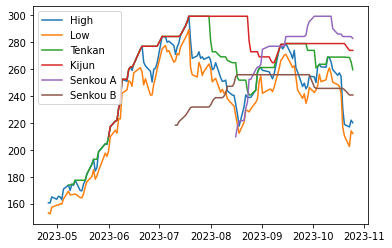

In [4]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Download stock data
ticker = "TSLA" 
data = yf.download(ticker, period="6mo", interval="1d")

# Calculate Ichimoku components
tenkan_period = 9
kijun_period = 26
senkou_period = 52

data['Tenkan'] = data['High'].rolling(window=tenkan_period).max() 
data['Kijun'] = data['High'].rolling(window=kijun_period).max()

data['Senkou A'] = ((data['Tenkan'] + data['Kijun']) / 2).shift(senkou_period)  
data['Senkou B'] = (data['High'].rolling(window=senkou_period).max() + data['Low'].rolling(window=senkou_period).min()) / 2

# Plot Ichimoku cloud chart
plt.plot(data['High'], label='High')
plt.plot(data['Low'], label='Low')
plt.plot(data['Tenkan'], label='Tenkan')
plt.plot(data['Kijun'], label='Kijun')
plt.plot(data['Senkou A'], label='Senkou A')
plt.plot(data['Senkou B'], label='Senkou B')
plt.legend()
plt.show()

In [128]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Download stock data
ticker = "TSLA" 
data = yf.download(ticker, period="8mo", interval="1d")

# Calculate Ichimoku components
tenkan_period = 9
kijun_period = 26
senkou_period = 52

data['Tenkan'] = data['High'].rolling(window=tenkan_period).max() 
data['Kijun'] = data['High'].rolling(window=kijun_period).max()

data['Senkou A'] = ((data['Tenkan'] + data['Kijun']) / 2).shift(senkou_period)  
data['Senkou B'] = (data['High'].rolling(window=senkou_period).max() + data['Low'].rolling(window=senkou_period).min()) / 2

total_data_points = data.shape[0]
print("Total data points:", total_data_points)

# Print the count of NAs before filling
na_count_before = data.isna().sum()
print("NAs count before filling:")
print(na_count_before)

# Normalize components to 0-255 range
# Fill missing values with a constant (0 in this case)
tenkan_norm = np.round((data['Tenkan'].fillna(0) - data['Tenkan'].min()) /
                       (data['Tenkan'].max() - data['Tenkan'].min()) * 255).astype(int)

kijun_norm = np.round((data['Kijun'].fillna(0) - data['Kijun'].min()) /
                      (data['Kijun'].max() - data['Kijun'].min()) * 255).astype(int)

senkouA_norm = np.round((data['Senkou A'].fillna(0) - data['Senkou A'].min()) /
                       (data['Senkou A'].max() - data['Senkou A'].min()) * 255).astype(int)

senkouB_norm = np.round((data['Senkou B'].fillna(0) - data['Senkou B'].min()) /
                       (data['Senkou B'].max() - data['Senkou B'].min()) * 255).astype(int)


# Construct image samples 
X = []
y = []

# Look at historical windows
input_window = 20
output_window = 5  

for i in range(input_window, len(data)-output_window):
  x_i = np.dstack([tenkan_norm.values[i-input_window:i],
                   kijun_norm.values[i-input_window:i],
                   senkouA_norm.values[i-input_window:i], 
                   senkouB_norm.values[i-input_window:i]])
  X.append(x_i)
  y.append(data['Close'].values[i+output_window] > data['Close'].values[i])

X = np.array(X)  
X = X.reshape(-1, input_window, 4, 1)  # 4 channels
y = np.array(y)

# Print the number of images used
num_images = len(X)
print("Number of images used:", num_images)

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the training and validation data
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

# Define the CNN model
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(20, 4, 1)))
model.add(Dropout(0.5))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Print the CNN architecture summary
model.summary()

# Compile and train the model
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=50, batch_size=32)

# Evaluate the model on the validation set
mse = model.evaluate(X_val, y_val)
print("Mean Squared Error on Validation Set:", mse)

[*********************100%%**********************]  1 of 1 completed
Total data points: 168
NAs count before filling:
Open          0
High          0
Low           0
Close         0
Adj Close     0
Volume        0
Tenkan        8
Kijun        25
Senkou A     77
Senkou B     51
dtype: int64
Number of images used: 143
X_train shape: (114, 20, 4, 1)
y_train shape: (114,)
X_val shape: (29, 20, 4, 1)
y_val shape: (29,)
Model: "sequential_61"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_63 (Conv2D)          (None, 18, 2, 16)         160       
                                                                 
 dropout_9 (Dropout)         (None, 18, 2, 16)         0         
                                                                 
 max_pooling2d_60 (MaxPoolin  (None, 9, 1, 16)         0         
 g2D)                                                            
                               

1/1 [==============================] - 0s 13ms/step


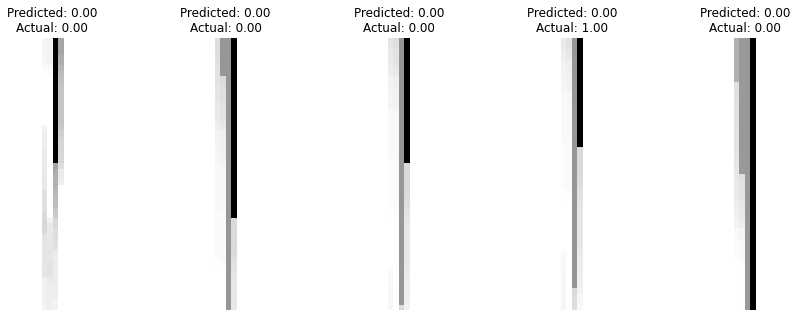

1/1 [==============================] - 0s 14ms/step - loss: 0.4667
Mean Squared Error on Validation Set: 0.4667


In [43]:
# Print some of the images
import random
import matplotlib.pyplot as plt

# Randomly select and display a few images and their corresponding predictions
num_samples = 5
selected_indices = random.sample(range(X_val.shape[0]), num_samples)
plt.figure(figsize=(15, 5))
for i, idx in enumerate(selected_indices):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(X_val[idx, :, :, 0], cmap='gray')
    plt.title(f"Predicted: {model.predict(X_val[idx:idx+1])[0][0]:.2f}\nActual: {y_val[idx]:.2f}")
    plt.axis('off')
plt.show()

# Interpretation of the MSE result
mse = model.evaluate(X_val, y_val)
print(f"Mean Squared Error on Validation Set: {mse:.4f}")


In [51]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Download stock data
ticker = "TSLA" 
data = yf.download(ticker, period="6mo", interval="1d")

# Calculate Ichimoku components
tenkan_period = 9
kijun_period = 26
senkou_period = 52

data['Tenkan'] = data['High'].rolling(window=tenkan_period).max() 
data['Kijun'] = data['High'].rolling(window=kijun_period).max()

data['Senkou A'] = ((data['Tenkan'] + data['Kijun']) / 2).shift(senkou_period)  
data['Senkou B'] = (data['High'].rolling(window=senkou_period).max() + data['Low'].rolling(window=senkou_period).min()) / 2

total_data_points = data.shape[0]
print("Total data points:", total_data_points)

# Print the count of NAs before filling
na_count_before = data.isna().sum()
print("NAs count before filling:")
print(na_count_before)

# Normalize components to 0-255 range
# Fill missing values with a constant (0 in this case)
tenkan_norm = np.round((data['Tenkan'].fillna(0) - data['Tenkan'].min()) /
                       (data['Tenkan'].max() - data['Tenkan'].min()) * 255).astype(int)

kijun_norm = np.round((data['Kijun'].fillna(0) - data['Kijun'].min()) /
                      (data['Kijun'].max() - data['Kijun'].min()) * 255).astype(int)

senkouA_norm = np.round((data['Senkou A'].fillna(0) - data['Senkou A'].min()) /
                       (data['Senkou A'].max() - data['Senkou A'].min()) * 255).astype(int)

senkouB_norm = np.round((data['Senkou B'].fillna(0) - data['Senkou B'].min()) /
                       (data['Senkou B'].max() - data['Senkou B'].min()) * 255).astype(int)


# Construct image samples 
X = []
y = []

# Look at historical windows
input_window = 50
output_window = 5  

for i in range(input_window, len(data)-output_window):
    if not any(data['Tenkan'].isna().iloc[i-input_window:i]) and \
       not any(data['Kijun'].isna().iloc[i-input_window:i]) and \
       not any(data['Senkou A'].isna().iloc[i-input_window:i]) and \
       not any(data['Senkou B'].isna().iloc[i-input_window:i]):

        x_i = np.dstack([tenkan_norm.values[i-input_window:i],
                        kijun_norm.values[i-input_window:i],
                        senkouA_norm.values[i-input_window:i], 
                        senkouB_norm.values[i-input_window:i]])
        X.append(x_i)
        y.append(data['Close'].values[i+output_window] > data['Close'].values[i])

X = np.array(X)  
X = X.reshape(-1, input_window, 4, 1)  # 4 channels
y = np.array(y)

# Print the number of images used
num_images = len(X)
print("Number of images used:", num_images)

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the training and validation data
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

# Define the CNN model
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(50, 4, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Print the CNN architecture summary
model.summary()

# Compile and train the model
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=50, batch_size=32)

# Evaluate the model on the validation set
mse = model.evaluate(X_val, y_val)
print("Mean Squared Error on Validation Set:", mse)


[*********************100%%**********************]  1 of 1 completed
Total data points: 127
NAs count before filling:
Open          0
High          0
Low           0
Close         0
Adj Close     0
Volume        0
Tenkan        8
Kijun        25
Senkou A     77
Senkou B     51
dtype: int64
Number of images used: 0


ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [50]:
import yfinance as yf
import pandas as pd

# Download stock data
ticker = "TSLA" 
data = yf.download(ticker, period="6mo", interval="1d")

# Calculate Ichimoku components
tenkan_period = 9
kijun_period = 26
senkou_period = 52

total_data_points = data.shape[0]
print("Total data points:", total_data_points)
# Interpolate NAs in the data
data.interpolate(method='linear', inplace=True)

# Calculate Tenkan-sen
data['Tenkan'] = data['High'].rolling(window=tenkan_period).max() 

# Calculate Kijun-sen
data['Kijun'] = data['High'].rolling(window=kijun_period).max()

# Calculate Senkou Span A
data['Senkou A'] = ((data['Tenkan'] + data['Kijun']) / 2).shift(senkou_period)

# Calculate Senkou Span B
data['Senkou B'] = (data['High'].rolling(window=senkou_period).max() + data['Low'].rolling(window=senkou_period).min()) / 2

# Check the NAs count after filling
na_count_after = data.isna().sum()
print("NAs count after filling:")
print(na_count_after)


[*********************100%%**********************]  1 of 1 completed
Total data points: 127
NAs count after filling:
Open          0
High          0
Low           0
Close         0
Adj Close     0
Volume        0
Tenkan        8
Kijun        25
Senkou A     77
Senkou B     51
dtype: int64


In [124]:
import numpy as np
import yfinance as yf
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define a list of stock tickers
tickers = ["TSLA", "AAPL", "GOOG","COST","BAC","AMD"]

# Create an empty list to store dataframes for each stock
data_frames = []

# Download data for each stock and store it in the list
for ticker in tickers:
    data = yf.download(ticker, period="8mo", interval="1d")
    data['Ticker'] = ticker  # Ad,"COST","BAC","AMD"d a Ticker column to identify the stock
    data_frames.append(data)

# Concatenate data for all stocks along the time axis
data = pd.concat(data_frames)

# Calculate Ichimoku components for each stock
tenkan_period = 4
kijun_period = 13
senkou_period = 26

for ticker in tickers:
    data[f'{ticker}_Tenkan'] = data[data['Ticker'] == ticker]['High'].rolling(window=tenkan_period).max()
    data[f'{ticker}_Kijun'] = data[data['Ticker'] == ticker]['High'].rolling(window=kijun_period).max()
    data[f'{ticker}_Senkou A'] = (
        (data[f'{ticker}_Tenkan'] + data[f'{ticker}_Kijun']) / 2
    ).shift(senkou_period)
    data[f'{ticker}_Senkou B'] = (
        (data[data['Ticker'] == ticker]['High'].rolling(window=senkou_period).max() + data[data['Ticker'] == ticker]['Low'].rolling(window=senkou_period).min())
        / 2
    )

# Total data points
total_data_points = data.shape[0]
print("Total data points:", total_data_points)
data.dropna(inplace=True)
data.interpolate(method='linear', inplace=True)


# Normalize components
for ticker in tickers:
    data[f'{ticker}_Tenkan'] = np.round(
        (data[f'{ticker}_Tenkan'] - data[f'{ticker}_Tenkan'].min())
        / (data[f'{ticker}_Tenkan'].max() - data[f'{ticker}_Tenkan'].min())
        * 255
    ).astype(int)
    data[f'{ticker}_Kijun'] = np.round(
        (data[f'{ticker}_Kijun'] - data[f'{ticker}_Kijun'].min())
        / (data[f'{ticker}_Kijun'].max() - data[f'{ticker}_Kijun'].min())
        * 255
    ).astype(int)
    data[f'{ticker}_Senkou A'] = np.round(
        (data[f'{ticker}_Senkou A'] - data[f'{ticker}_Senkou A'].min())
        / (data[f'{ticker}_Senkou A'].max() - data[f'{ticker}_Senkou A'].min())
        * 255
    ).astype(int)
    data[f'{ticker}_Senkou B'] = np.round(
        (data[f'{ticker}_Senkou B'] - data[f'{ticker}_Senkou B'].min())
        / (data[f'{ticker}_Senkou B'].max() - data[f'{ticker}_Senkou B'].min())
        * 255
    ).astype(int)

# Construct image samples
X = []
y = []

input_window = 20
output_window = 5

# Determine the minimum number of data points for all stocks
min_data_points = data.groupby('Ticker').size().min()

for i in range(input_window, min_data_points - output_window):
    x_i = np.dstack(
        [
            data[data['Ticker'] == ticker][f'{ticker}_Tenkan'].values[i - input_window:i],
            data[data['Ticker'] == ticker][f'{ticker}_Kijun'].values[i - input_window:i],
            data[data['Ticker'] == ticker][f'{ticker}_Senkou A'].values[i - input_window:i],
            data[data['Ticker'] == ticker][f'{ticker}_Senkou B'].values[i - input_window:i],
        ]
    )
    X.append(x_i)
    y.append(
        data[data['Ticker'] == ticker]['Close'].values[i + output_window]
        > data[data['Ticker'] == ticker]['Close'].values[i]
    )

X = np.array(X)
X = X.reshape(-1, input_window, 4, 1)
y = np.array(y)

# Print the number of images used
num_images = len(X)
print("Number of images used:", num_images)

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the training and validation data
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

# Define the CNN model
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(20, 4, 1)))
model.add(Dropout(0.5))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.add(Dropout(0.5))
# Print the CNN architecture summary
model.summary()

# Compile and train the model
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=50, batch_size=32)

# Evaluate the model on the validation set
mse = model.evaluate(X_val, y_val)
print("Mean Squared Error on Validation Set:", mse)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Total data points: 1008


C:\Users\beaud\AppData\Local\Temp\ipykernel_928\1135569292.py:43: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data.interpolate(method='linear', inplace=True)


Number of images used: 105
X_train shape: (84, 20, 4, 1)
y_train shape: (84,)
X_val shape: (21, 20, 4, 1)
y_val shape: (21,)
Model: "sequential_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_61 (Conv2D)          (None, 18, 2, 16)         160       
                                                                 
 dropout_3 (Dropout)         (None, 18, 2, 16)         0         
                                                                 
 max_pooling2d_58 (MaxPoolin  (None, 9, 1, 16)         0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 9, 1, 16)          0         
                                                                 
 flatten_56 (Flatten)        (None, 144)               0         
                                                            

Epoch 1/150
9/9 [==============================] - 0s 7ms/step - loss: 0.2435 - accuracy: 0.8856 - val_loss: 0.9504 - val_accuracy: 0.7647
Epoch 2/150
9/9 [==============================] - 0s 4ms/step - loss: 0.2841 - accuracy: 0.8708 - val_loss: 0.8791 - val_accuracy: 0.7059
Epoch 3/150
9/9 [==============================] - 0s 4ms/step - loss: 0.1754 - accuracy: 0.9410 - val_loss: 0.7342 - val_accuracy: 0.7500
Epoch 4/150
9/9 [==============================] - 0s 4ms/step - loss: 0.1960 - accuracy: 0.9114 - val_loss: 0.8232 - val_accuracy: 0.7353
Epoch 5/150
9/9 [==============================] - 0s 4ms/step - loss: 0.1502 - accuracy: 0.9483 - val_loss: 0.8501 - val_accuracy: 0.7500
Epoch 6/150
9/9 [==============================] - 0s 4ms/step - loss: 0.2023 - accuracy: 0.9004 - val_loss: 0.9179 - val_accuracy: 0.7500
Epoch 7/150
9/9 [==============================] - 0s 4ms/step - loss: 0.1722 - accuracy: 0.9410 - val_loss: 0.8235 - val_accuracy: 0.7353
Epoch 8/150
9/9 [==========

9/9 [==============================] - 0s 4ms/step - loss: 0.0443 - accuracy: 0.9779 - val_loss: 0.7599 - val_accuracy: 0.8235
Epoch 118/150
9/9 [==============================] - 0s 4ms/step - loss: 0.0442 - accuracy: 0.9852 - val_loss: 0.7555 - val_accuracy: 0.8235
Epoch 119/150
9/9 [==============================] - 0s 4ms/step - loss: 0.0732 - accuracy: 0.9742 - val_loss: 0.8290 - val_accuracy: 0.8529
Epoch 120/150
9/9 [==============================] - 0s 4ms/step - loss: 0.0543 - accuracy: 0.9779 - val_loss: 0.7892 - val_accuracy: 0.8382
Epoch 121/150
9/9 [==============================] - 0s 4ms/step - loss: 0.0416 - accuracy: 0.9926 - val_loss: 0.7889 - val_accuracy: 0.8235
Epoch 122/150
9/9 [==============================] - 0s 4ms/step - loss: 0.0341 - accuracy: 0.9889 - val_loss: 1.0378 - val_accuracy: 0.7353
Epoch 123/150
9/9 [==============================] - 0s 4ms/step - loss: 0.0409 - accuracy: 0.9963 - val_loss: 0.7610 - val_accuracy: 0.8235
Epoch 124/150
9/9 [========

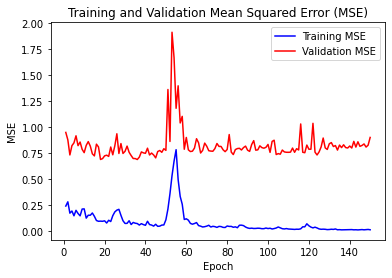

In [88]:
import matplotlib.pyplot as plt

# Assuming you have trained your model and stored the training history
history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_data=(X_val, y_val))

# Access the MSE values from the history
train_mse = history.history['loss']
val_mse = history.history['val_loss']

# Plot both training and validation MSE
plt.plot(range(1, len(train_mse) + 1), train_mse, label='Training MSE', color='blue')
plt.plot(range(1, len(val_mse) + 1), val_mse, label='Validation MSE', color='red')
plt.title('Training and Validation Mean Squared Error (MSE)')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()


In [9]:
#train model for decisions
import numpy as np
import pandas as pd
import yfinance as yf  # Import yfinance library
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Download stock data
ticker = "TSLA" 
data = yf.download(ticker, period="8mo", interval="1d")

# Calculate Ichimoku components
tenkan_period = 9
kijun_period = 26
senkou_period = 52

data['Tenkan'] = data['High'].rolling(window=tenkan_period).max() 
data['Kijun'] = data['High'].rolling(window=kijun_period).max()

data['Senkou A'] = ((data['Tenkan'] + data['Kijun']) / 2).shift(senkou_period)  
data['Senkou B'] = (data['High'].rolling(window=senkou_period).max() + data['Low'].rolling(window=senkou_period).min()) / 2

# Calculate additional indicators
ma_period = 20
data['MA'] = data['Close'].rolling(ma_period).mean()

# Calculate RSI without using talib
rsi_period = 14
delta = data['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
average_gain = gain.rolling(window=rsi_period).mean()
average_loss = loss.rolling(window=rsi_period).mean()
rs = average_gain / average_loss
data['RSI'] = 100 - (100 / (1 + rs))

# Define a function to normalize and fill non-finite values
def normalize_and_fill(column):
    min_val = column.min()
    max_val = column.max()
    column = ((column - min_val) / (max_val - min_val)) * 255
    return column.fillna(0).astype(int)

data['Tenkan'] = normalize_and_fill(data['Tenkan'])
data['Kijun'] = normalize_and_fill(data['Kijun'])
data['Senkou A'] = normalize_and_fill(data['Senkou A'])
data['Senkou B'] = normalize_and_fill(data['Senkou B'])
data['MA'] = normalize_and_fill(data['MA'])
data['RSI'] = normalize_and_fill(data['RSI'])


# Construct image samples
X = []
y = []
input_window = 50
output_window = 5
for i in range(input_window, len(data) - output_window):
    x_i = np.dstack([
        data['Tenkan'].values[i - input_window:i],
        data['Kijun'].values[i - input_window:i],
        data['Senkou A'].values[i - input_window:i],
        data['Senkou B'].values[i - input_window:i],
        data['MA'].values[i - input_window:i],
        data['RSI'].values[i - input_window:i]
    ])

    X.append(x_i)

    y.append(data['Close'].values[i + output_window] > data['Close'].values[i])

X = np.array(X)
X = X.reshape(-1, input_window, 6, 1)
# Convert y to a NumPy array
y = np.array(y)

# Train test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2) 

# Define model
input_shape = (input_window, 6, 1)  # Adjust the input shape to match the data
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

# Compile and train
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

# Evaluate the model on the validation set
mse = model.evaluate(X_val, y_val)
print("Mean Squared Error on Validation Set:", mse)

[*********************100%%**********************]  1 of 1 completed
Epoch 1/50
3/3 [==============================] - 0s 3ms/step - loss: 10.7942 - accuracy: 0.5055
Epoch 2/50
3/3 [==============================] - 0s 3ms/step - loss: 10.3106 - accuracy: 0.5055
Epoch 3/50
3/3 [==============================] - 0s 3ms/step - loss: 3.9059 - accuracy: 0.5714
Epoch 4/50
3/3 [==============================] - 0s 2ms/step - loss: 6.1649 - accuracy: 0.4945
Epoch 5/50
3/3 [==============================] - 0s 3ms/step - loss: 2.8053 - accuracy: 0.6044
Epoch 6/50
3/3 [==============================] - 0s 2ms/step - loss: 4.2252 - accuracy: 0.5714
Epoch 7/50
3/3 [==============================] - 0s 3ms/step - loss: 2.0970 - accuracy: 0.6923
Epoch 8/50
3/3 [==============================] - 0s 3ms/step - loss: 2.0870 - accuracy: 0.6484
Epoch 9/50
3/3 [==============================] - 0s 3ms/step - loss: 1.2042 - accuracy: 0.7253
Epoch 10/50
3/3 [==============================] - 0s 2ms/step - 

In [100]:
import yfinance as yf
import numpy as np
import pandas as pd

# Download the latest data for TSLA
ticker = "TSLA"
data = yf.download(ticker, period="1mo", interval="1m")  # Adjust the period and interval as needed

# Calculate Ichimoku components (Tenkan, Kijun, Senkou A, Senkou B) and additional indicators (MA and RSI)
tenkan_period = 9
kijun_period = 26
senkou_period = 52
ma_period = 20
rsi_period = 14

data['Tenkan'] = data['High'].rolling(window=tenkan_period).max()
data['Kijun'] = data['High'].rolling(window=kijun_period).max()

data['Senkou A'] = ((data['Tenkan'] + data['Kijun']) / 2).shift(senkou_period)
data['Senkou B'] = (data['High'].rolling(window=senkou_period).max() + data['Low'].rolling(window=senkou_period).min()) / 2

delta = data['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
average_gain = gain.rolling(window=rsi_period).mean()
average_loss = loss.rolling(window=rsi_period).mean()
rs = average_gain / average_loss
data['RSI'] = 100 - (100 / (1 + rs))

# Calculate Moving Average (MA) for the data
data['MA'] = data['Close'].rolling(ma_period).mean()

# Normalize the data
def normalize_column(column):
    min_val = column.min()
    max_val = column.max()
    column = ((column - min_val) / (max_val - min_val)) * 255
    return column.fillna(0).astype(int)

data['Tenkan'] = normalize_column(data['Tenkan'])
data['Kijun'] = normalize_column(data['Kijun'])
data['Senkou A'] = normalize_column(data['Senkou A'])
data['Senkou B'] = normalize_column(data['Senkou B'])
data['RSI'] = normalize_column(data['RSI'])

# Construct input data for prediction
input_window = 50  # Should match your training window size
output_window = 5   # Should match your training output window

X = []

for i in range(input_window, len(data) - output_window):
    x_i = np.dstack([
        data['Tenkan'].values[i - input_window:i],
        data['Kijun'].values[i - input_window:i],
        data['Senkou A'].values[i - input_window:i],
        data['Senkou B'].values[i - input_window:i],
        data['MA'].values[i - input_window:i],
        data['RSI'].values[i - input_window:i]
    ])

    X.append(x_i)

# Make sure X is a 4D numpy array with the shape (number of samples, input_window, number of features, 1)
X = np.array(X)
X = X.reshape(-1, input_window, 6, 1)

# Now, you can use your trained model to make predictions using this input data

# Make predictions using your trained model
predictions = model.predict(X)  # This will output probabilities
print(len(predictions))
# Implement a threshold to make trading decisions
threshold = 0.5  # Adjust this threshold as needed

# Make trading decisions based on the predictions
trading_decisions = (predictions > threshold).astype(int)
print(len(trading_decisions))

[*********************100%%**********************]  1 of 1 completed
10/10 [==============================] - 0s 1ms/step
307
307


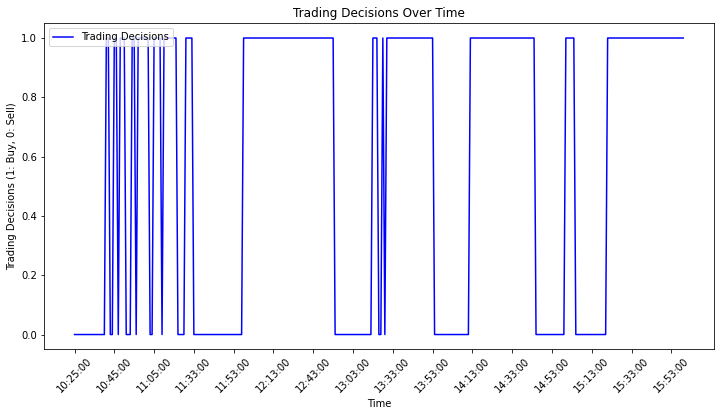

Latest Decision: Buy


In [101]:
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np

# Assuming 'data' is your DataFrame with timestamp as the index
timestamps = data.index

# Convert timestamps to time (hh:mm:ss) strings
time_of_day = [timestamp.strftime('%H:%M:%S') for timestamp in timestamps]
time_of_day = time_of_day[-len(trading_decisions):]

# Create an array of indices for x-axis labels
x_indices = np.arange(0, len(time_of_day), step=20)  # You can adjust the step as needed

# Create an array of x-axis labels based on the selected indices
x_labels = [time_of_day[i] for i in x_indices]

# Plot the trading decisions
plt.figure(figsize=(12, 6))
plt.plot(time_of_day, trading_decisions, label='Trading Decisions', color='b')
plt.xlabel('Time')
plt.ylabel('Trading Decisions (1: Buy, 0: Sell)')
plt.title('Trading Decisions Over Time')
plt.xticks(x_indices, x_labels, rotation=45)  # Set the x-axis labels
plt.legend(loc='upper left')
plt.show()

# Print the latest or final decision
latest_decision = trading_decisions[-1]
print("Latest Decision: Buy" if latest_decision == 1 else "Latest Decision: Do Not Buy")


In [93]:
import numpy as np
import pandas as pd
import yfinance as yf  # Import yfinance library
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define a list of stock tickers
tickers = ["TSLA", "AAPL", "GOOGL", "COST", "GME", "NFLX", "GLD", "NVDA", "PLTR" ]  # Add more tickers as needed

# Create an empty dictionary to hold the data for each stock
stock_data = {}

for ticker in tickers:
    data = yf.download(ticker, period="ytd", interval="1d")
    stock_data[ticker] = data

# Calculate Ichimoku components, additional indicators, and normalization for each stock
tenkan_period = 9
kijun_period = 26
senkou_period = 52
ma_period = 20
rsi_period = 14

def normalize_and_fill(column):
    min_val = column.min()
    max_val = column.max()
    column = ((column - min_val) / (max_val - min_val)) * 255
    return column.fillna(0).astype(int)

for ticker in tickers:
    stock_data[ticker]['Tenkan'] = stock_data[ticker]['High'].rolling(window=tenkan_period).max()
    stock_data[ticker]['Kijun'] = stock_data[ticker]['High'].rolling(window=kijun_period).max()
    
    stock_data[ticker]['Senkou A'] = ((stock_data[ticker]['Tenkan'] + stock_data[ticker]['Kijun']) / 2).shift(senkou_period)
    stock_data[ticker]['Senkou B'] = (stock_data[ticker]['High'].rolling(window=senkou_period).max() + stock_data[ticker]['Low'].rolling(window=senkou_period).min()) / 2
    
    stock_data[ticker]['MA'] = stock_data[ticker]['Close'].rolling(ma_period).mean()

    delta = stock_data[ticker]['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    average_gain = gain.rolling(window=rsi_period).mean()
    average_loss = loss.rolling(window=rsi_period).mean()
    rs = average_gain / average_loss
    stock_data[ticker]['RSI'] = 100 - (100 / (1 + rs))

    # Normalize and fill non-finite values for each indicator
    stock_data[ticker]['Tenkan'] = normalize_and_fill(stock_data[ticker]['Tenkan'])
    stock_data[ticker]['Kijun'] = normalize_and_fill(stock_data[ticker]['Kijun'])
    stock_data[ticker]['Senkou A'] = normalize_and_fill(stock_data[ticker]['Senkou A'])
    stock_data[ticker]['Senkou B'] = normalize_and_fill(stock_data[ticker]['Senkou B'])
    stock_data[ticker]['MA'] = normalize_and_fill(stock_data[ticker]['MA'])
    stock_data[ticker]['RSI'] = normalize_and_fill(stock_data[ticker]['RSI'])

# Construct image samples
X = []
y = []
input_window = 50
output_window = 5

for ticker in tickers:
    for i in range(input_window, len(stock_data[ticker]) - output_window):
        x_i = np.dstack([
            stock_data[ticker]['Tenkan'].values[i - input_window:i],
            stock_data[ticker]['Kijun'].values[i - input_window:i],
            stock_data[ticker]['Senkou A'].values[i - input_window:i],
            stock_data[ticker]['Senkou B'].values[i - input_window:i],
            stock_data[ticker]['MA'].values[i - input_window:i],
            stock_data[ticker]['RSI'].values[i - input_window:i]
        ])
        
        X.append(x_i)
        y.append(stock_data[ticker]['Close'].values[i + output_window] > stock_data[ticker]['Close'].values[i])
# Print the number of images
print(f"Number of images input into the model: {len(X)}")
X = np.array(X)
X = X.reshape(-1, input_window, 6, 1)
y = np.array(y)

# Train test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

# Define the model
input_shape = (input_window, 6, 1)
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

# Compile and train the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

# Evaluate the model on the validation set
mse = model.evaluate(X_val, y_val)
print("Mean Squared Error on Validation Set:", mse)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Number of images input into the model: 1314
Epoch 1/50
33/33 [==============================] - 0s 2ms/step - loss: 2.7569 - accuracy: 0.5480
Epoch 2/50
33/33 [==============================] - 0s 2ms/step - loss: 1.5493 - accuracy: 0.5966
Epoch 3/50
33/33 [==============================] - 0s 2ms/step - loss: 1.1358 - accuracy: 0.6175
Epoch 4/50
33/33 [=======================

In [ ]:
# 3 stocks 339 images, Mean Squared Error on Validation Set: [1.0082502365112305, 0.720588207244873]
# 6 678; Mean Squared Error on Validation Set: [0.9736000299453735, 0.7573529481887817]
# 9 1314, Mean Squared Error on Validation Set: [1.0778952836990356, 0.6577946543693542]

[*********************100%%**********************]  1 of 1 completed
NAs count before filling:
Open          0
High          0
Low           0
Close         0
Adj Close     0
Volume        0
Tenkan        8
Kijun        25
Senkou A     77
Senkou B     51
MA           19
RSI          13
dtype: int64
NAs count after filling:
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Tenkan       0
Kijun        0
Senkou A     0
Senkou B     0
MA           0
RSI          0
dtype: int64


C:\Users\beaud\AppData\Local\Temp\ipykernel_15336\3231407820.py:44: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Tenkan'].fillna(method='bfill', inplace=True)
C:\Users\beaud\AppData\Local\Temp\ipykernel_15336\3231407820.py:45: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Kijun'].fillna(method='bfill', inplace=True)
C:\Users\beaud\AppData\Local\Temp\ipykernel_15336\3231407820.py:46: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Senkou A'].fillna(method='bfill', inplace=True)
C:\Users\beaud\AppData\Local\Temp\ipykernel_15336\3231407820.py:47: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Senkou B'].fillna(method=

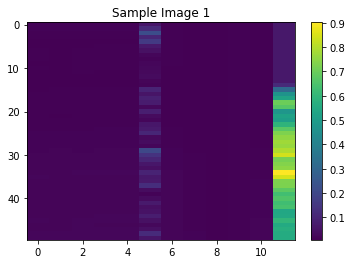

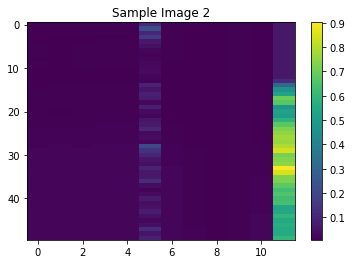

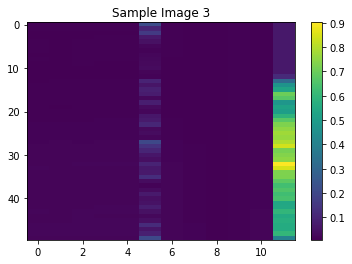

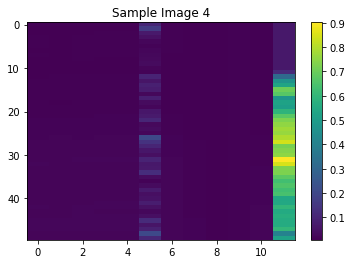

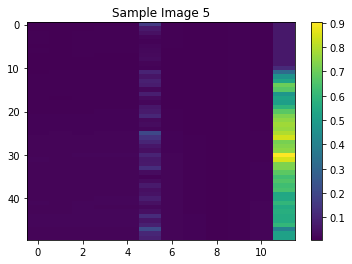

Epoch 1/200
82/82 [==============================] - 1s 4ms/step - loss: 4184.0381
Epoch 2/200
82/82 [==============================] - 0s 4ms/step - loss: 882.3953
Epoch 3/200
82/82 [==============================] - 0s 4ms/step - loss: 688.8009
Epoch 4/200
82/82 [==============================] - 0s 4ms/step - loss: 696.1069
Epoch 5/200
82/82 [==============================] - 0s 4ms/step - loss: 754.2535
Epoch 6/200
82/82 [==============================] - 0s 4ms/step - loss: 545.7926
Epoch 7/200
82/82 [==============================] - 0s 4ms/step - loss: 468.2009
Epoch 8/200
82/82 [==============================] - 0s 4ms/step - loss: 479.9636
Epoch 9/200
82/82 [==============================] - 0s 4ms/step - loss: 404.8607
Epoch 10/200
82/82 [==============================] - 0s 4ms/step - loss: 364.7473
Epoch 11/200
82/82 [==============================] - 0s 4ms/step - loss: 388.5142
Epoch 12/200
82/82 [==============================] - 0s 4ms/step - loss: 524.4863
Epoch 13/200

Epoch 100/200
82/82 [==============================] - 0s 4ms/step - loss: 95.1297
Epoch 101/200
82/82 [==============================] - 0s 4ms/step - loss: 95.0664
Epoch 102/200
82/82 [==============================] - 0s 4ms/step - loss: 103.8049
Epoch 103/200
82/82 [==============================] - 0s 4ms/step - loss: 99.7426
Epoch 104/200
82/82 [==============================] - 0s 4ms/step - loss: 117.9957
Epoch 105/200
82/82 [==============================] - 0s 4ms/step - loss: 87.2296
Epoch 106/200
82/82 [==============================] - 0s 4ms/step - loss: 109.4369
Epoch 107/200
82/82 [==============================] - 0s 4ms/step - loss: 89.6991
Epoch 108/200
82/82 [==============================] - 0s 4ms/step - loss: 70.7503
Epoch 109/200
82/82 [==============================] - 0s 4ms/step - loss: 79.3006
Epoch 110/200
82/82 [==============================] - 0s 4ms/step - loss: 69.8676
Epoch 111/200
82/82 [==============================] - 0s 4ms/step - loss: 63.2642
E

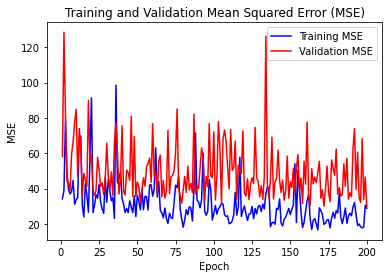

In [95]:
#train model for closing prices
import numpy as np
import pandas as pd
import yfinance as yf  # Import yfinance library
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Download stock data
ticker = "TSLA" 
data = yf.download(ticker, period="80mo", interval="1d")

# Calculate Ichimoku components
tenkan_period = 9
kijun_period = 26
senkou_period = 52

data['Tenkan'] = data['High'].rolling(window=tenkan_period).max() 
data['Kijun'] = data['High'].rolling(window=kijun_period).max()

data['Senkou A'] = ((data['Tenkan'] + data['Kijun']) / 2).shift(senkou_period)  
data['Senkou B'] = (data['High'].rolling(window=senkou_period).max() + data['Low'].rolling(window=senkou_period).min()) / 2

# Calculate additional indicators
ma_period = 20
data['MA'] = data['Close'].rolling(ma_period).mean()

# Calculate RSI without using talib
rsi_period = 14
delta = data['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
average_gain = gain.rolling(window=rsi_period).mean()
average_loss = loss.rolling(window=rsi_period).mean()
rs = average_gain / average_loss
data['RSI'] = 100 - (100 / (1 + rs))

# Check the NAs before filling
na_count_before = data.isna().sum()
print("NAs count before filling:")
print(na_count_before)

# Backward-fill NAs
data['Tenkan'].fillna(method='bfill', inplace=True)
data['Kijun'].fillna(method='bfill', inplace=True)
data['Senkou A'].fillna(method='bfill', inplace=True)
data['Senkou B'].fillna(method='bfill', inplace=True)
data['MA'].fillna(method='bfill', inplace=True)
data['RSI'].fillna(method='bfill', inplace=True)

# Check the NAs count after filling
na_count_after = data.isna().sum()
print("NAs count after filling:")
print(na_count_after)

# Drop rows with remaining NAs
data.dropna(inplace=True)

# Construct input samples
X = []
y = []
input_window = 50
output_window = 1  # Predict the next closing price

for i in range(input_window, len(data) - output_window):
    x_i = np.dstack([
        data['Tenkan'].values[i - input_window:i],
        data['Kijun'].values[i - input_window:i],
        data['Senkou A'].values[i - input_window:i],
        data['Senkou B'].values[i - input_window:i],
        data['MA'].values[i - input_window:i],
        data['RSI'].values[i - input_window:i]
    ])

    X.append(x_i)
    y.append(data['Close'].values[i + output_window])  # Use the next closing price

X = np.array(X)
X = X.reshape(-1, input_window, 6, 1)

# Convert y to a NumPy array
y = np.array(y)

# Train test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2) 

# Define model for regression
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))  # Change activation function to linear for regression

# Compile and train
model.compile(loss='mse', optimizer='adam') # Use mean squared error as loss for regression
model.fit(X_train, y_train, epochs=200, batch_size=16, verbose=1)

# Evaluate the model on the validation set
mse = model.evaluate(X_val, y_val)
print("Mean Squared Error on Validation Set:", mse)

import matplotlib.pyplot as plt

history = model.fit(X_train, y_train, 
                    epochs=200, 
                    batch_size=16,
                    validation_data=(X_val, y_val), 
                    verbose=0)


# Access the MSE values from the history
train_mse = history.history['loss']
val_mse = history.history['val_loss']

# Plot both training and validation MSE
plt.plot(range(1, len(train_mse) + 1), train_mse, label='Training MSE', color='blue')
plt.plot(range(1, len(val_mse) + 1), val_mse, label='Validation MSE', color='red')
plt.title('Training and Validation Mean Squared Error (MSE)')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [15]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Download historical data for the stock (e.g., TSLA)
ticker = "TSLA"
data = yf.download(ticker, period="8mo", interval="1d")

# Calculate Ichimoku components, moving average (MA), and RSI as in your training code
tenkan_period = 9
kijun_period = 26
senkou_period = 52
ma_period = 20
rsi_period = 14

data['Tenkan'] = data['High'].rolling(window=tenkan_period).max()
data['Kijun'] = data['High'].rolling(window=kijun_period).max()

data['Senkou A'] = ((data['Tenkan'] + data['Kijun']) / 2).shift(senkou_period)
data['Senkou B'] = (data['High'].rolling(window=senkou_period).max() + data['Low'].rolling(window=senkou_period).min()) / 2

delta = data['Close'].diff()
gain = np.where(delta > 0, delta, 0)
loss = np.where(delta < 0, -delta, 0)

# Convert gain and loss to DataFrames to use rolling mean
gain = pd.Series(gain)
loss = pd.Series(loss)

average_gain = gain.rolling(window=rsi_period).mean()
average_loss = loss.rolling(window=rsi_period).mean()
rs = average_gain / average_loss
data['RSI'] = 100 - (100 / (1 + rs))

# Calculate Moving Average (MA) for the data
data['MA'] = data['Close'].rolling(ma_period).mean()

# Normalize and fill non-finite values
def normalize_and_fill(column):
    min_val = column.min()
    max_val = column.max()
    column = ((column - min_val) / (max_val - min_val)) * 255
    return column.fillna(0).astype(int)

data['Tenkan'] = normalize_and_fill(data['Tenkan'])
data['Kijun'] = normalize_and_fill(data['Kijun'])
data['Senkou A'] = normalize_and_fill(data['Senkou A'])
data['Senkou B'] = normalize_and_fill(data['Senkou B'])
data['MA'] = normalize_and_fill(data['MA'])
data['RSI'] = normalize_and_fill(data['RSI'])

# Extract and preprocess data for predictions
input_window = 50  # Should match your training window size
output_window = 5   # The number of days into the future to predict

X = []
y = []

for i in range(input_window, len(data) - output_window):
    x_i = np.dstack([
        data['Tenkan'].values[i - input_window:i],
        data['Kijun'].values[i - input_window:i],
        data['Senkou A'].values[i - input_window:i],
        data['Senkou B'].values[i - input_window:i],
        data['MA'].values[i - input_window:i],
        data['RSI'].values[i - input_window:i]
    ])

    X.append(x_i)
    y.append(data['Close'].values[i + output_window])

# Make sure X is a 4D numpy array with the shape (number of samples, input_window, number_of_features, 1)
X = np.array(X)
X = X.reshape(-1, input_window, number_of_features, 1)

# Convert y to a NumPy array
y = np.array(y)

# Make predictions using your trained model
predicted_closing_prices = model.predict(X)  # X is your input data

# Print the latest or final predicted closing price
latest_predicted_price = predicted_closing_prices[-1][0]
print("Latest Predicted Closing Price:", latest_predicted_price)

# Plot actual and predicted closing prices
plt.figure(figsize=(12, 6))
plt.plot(data.index[-output_window:], data['Close'][-output_window:], label='Actual Closing Price (Future)', color='green')
plt.plot(data.index[-output_window:], predicted_closing_prices[-output_window:], label='Predicted Closing Price (Future)', color='red')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Actual vs Predicted Closing Prices')
plt.legend()
plt.grid()
plt.show()


[*********************100%%**********************]  1 of 1 completed


ValueError: in user code:

    File "C:\Users\beaud\anaconda3\lib\site-packages\keras\engine\training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\beaud\anaconda3\lib\site-packages\keras\engine\training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\beaud\anaconda3\lib\site-packages\keras\engine\training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\beaud\anaconda3\lib\site-packages\keras\engine\training.py", line 2111, in predict_step
        return self(x, training=False)
    File "C:\Users\beaud\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\beaud\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_5" is incompatible with the layer: expected shape=(None, 10, 20, 1), found shape=(None, 50, 6, 1)


[*********************100%%**********************]  1 of 1 completed
NAs count before filling:
Open          0
High          0
Low           0
Close         0
Adj Close     0
Volume        0
Tenkan        8
Kijun        25
Senkou A     77
Senkou B     51
MA           19
RSI          13
dtype: int64
NAs count after filling:
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Tenkan       0
Kijun        0
Senkou A     0
Senkou B     0
MA           0
RSI          0
dtype: int64
Number of samples before generating images: 1679


C:\Users\beaud\AppData\Local\Temp\ipykernel_19068\1121541110.py:44: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Tenkan'].fillna(method='bfill', inplace=True)
C:\Users\beaud\AppData\Local\Temp\ipykernel_19068\1121541110.py:45: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Kijun'].fillna(method='bfill', inplace=True)
C:\Users\beaud\AppData\Local\Temp\ipykernel_19068\1121541110.py:46: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Senkou A'].fillna(method='bfill', inplace=True)
C:\Users\beaud\AppData\Local\Temp\ipykernel_19068\1121541110.py:47: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Senkou B'].fillna(method=

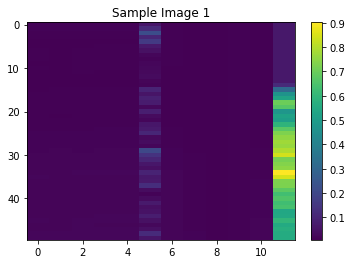

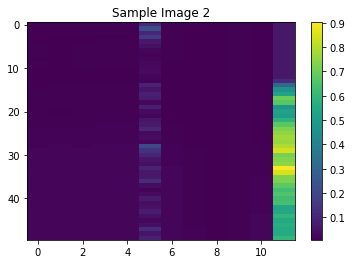

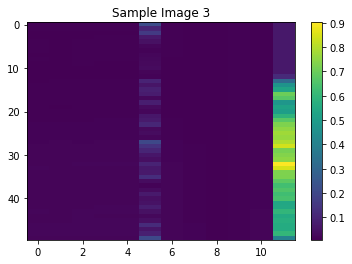

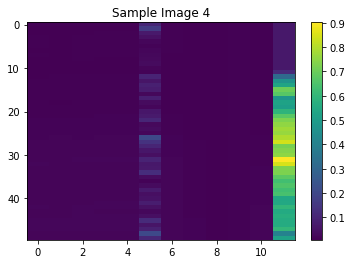

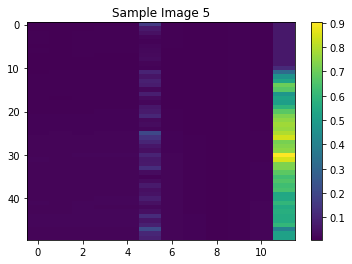

Number of samples after generating images: 1629
Look at X: [[0.01574875 0.01570612 0.01642177 0.01648416 0.01648416 0.06301565
  0.01365819 0.0081418  0.00872632 0.01315322 0.01012425 0.06617486]
 [0.01655998 0.01604605 0.01618311 0.01583431 0.01583431 0.11520909
  0.01365819 0.0081418  0.00872632 0.01315322 0.01012425 0.06617486]
 [0.01383754 0.01293036 0.01329889 0.01289992 0.01289992 0.219657
  0.01365819 0.0081418  0.00872632 0.01315322 0.01012425 0.06617486]
 [0.01194468 0.01186748 0.01239165 0.01306908 0.01306908 0.10531738
  0.01365819 0.0081418  0.00872632 0.01315322 0.01012425 0.06617486]
 [0.01119522 0.01022755 0.0110054  0.01126524 0.01126524 0.16108668
  0.01365819 0.0081418  0.00872632 0.01315322 0.01012425 0.06617486]
 [0.01053088 0.01066531 0.01132531 0.01189499 0.01189499 0.0698215
  0.01365819 0.0081418  0.00872632 0.01315322 0.01012425 0.06617486]
 [0.0121984  0.0113037  0.01220716 0.01190002 0.01190002 0.04831203
  0.01365819 0.0081418  0.00872632 0.01315322 0.010124

82/82 [==============================] - 0s 6ms/step - loss: 18.5523
Epoch 116/200
82/82 [==============================] - 1s 6ms/step - loss: 14.5841
Epoch 117/200
82/82 [==============================] - 0s 6ms/step - loss: 10.4683
Epoch 118/200
82/82 [==============================] - 1s 6ms/step - loss: 10.1652
Epoch 119/200
82/82 [==============================] - 0s 6ms/step - loss: 22.8019
Epoch 120/200
82/82 [==============================] - 1s 6ms/step - loss: 15.4703
Epoch 121/200
82/82 [==============================] - 0s 6ms/step - loss: 15.2427
Epoch 122/200
82/82 [==============================] - 1s 6ms/step - loss: 19.6846
Epoch 123/200
82/82 [==============================] - 0s 6ms/step - loss: 15.4586
Epoch 124/200
82/82 [==============================] - 1s 6ms/step - loss: 11.4351
Epoch 125/200
82/82 [==============================] - 0s 6ms/step - loss: 15.2023
Epoch 126/200
82/82 [==============================] - 1s 6ms/step - loss: 10.6624
Epoch 127/200
82/8

In [2]:
#train with images instead: 
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import matplotlib.pyplot as plt
# Download stock data
ticker = "TSLA"
data = yf.download(ticker, period="80mo", interval="1d")

# Calculate Ichimoku components
tenkan_period = 9
kijun_period = 26
senkou_period = 52

data['Tenkan'] = data['High'].rolling(window=tenkan_period).max()
data['Kijun'] = data['High'].rolling(window=kijun_period).max()

data['Senkou A'] = ((data['Tenkan'] + data['Kijun']) / 2).shift(senkou_period)
data['Senkou B'] = (data['High'].rolling(window=senkou_period).max() + data['Low'].rolling(window=senkou_period).min()) / 2

# Calculate additional indicators
ma_period = 20
data['MA'] = data['Close'].rolling(ma_period).mean()

# Calculate RSI without using talib
rsi_period = 14
delta = data['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
average_gain = gain.rolling(window=rsi_period).mean()
average_loss = loss.rolling(window=rsi_period).mean()
rs = average_gain / average_loss
data['RSI'] = 100 - (100 / (1 + rs))

# Check the NAs before filling
na_count_before = data.isna().sum()
print("NAs count before filling:")
print(na_count_before)

# Backward-fill NAs
data['Tenkan'].fillna(method='bfill', inplace=True)
data['Kijun'].fillna(method='bfill', inplace=True)
data['Senkou A'].fillna(method='bfill', inplace=True)
data['Senkou B'].fillna(method='bfill', inplace=True)
data['MA'].fillna(method='bfill', inplace=True)
data['RSI'].fillna(method='bfill', inplace=True)

# Check the NAs count after filling
na_count_after = data.isna().sum()
print("NAs count after filling:")
print(na_count_after)

print("Number of samples before generating images:", len(data))

# Create an empty array to store the images
images = []

# Normalize your data for better visualization (scaling to the [0, 1] range)
normalized_data = (data - data.min()) / (data.max() - data.min())

# Loop through the data and create images
for i in range(image_width, len(data)):
    image = normalized_data.iloc[i - image_width:i].values
    images.append(image)

# Convert the images list to a NumPy array
X = np.array(images)

# Visualize some of the images (optional)
num_sample_images = 5  # Change this to see more or fewer sample images

for i in range(num_sample_images):
    plt.figure()
    plt.imshow(X[i], cmap='viridis', aspect='auto')
    plt.title(f"Sample Image {i+1}")
    plt.colorbar()
    plt.show()
    
# Define the target variable
y = data['Close'].shift(-1).dropna().values
print("Number of samples after generating images:", len(X))
print("Look at X:",X[0])

# Ensure X and y have the same length
min_length = min(len(X), len(y))
X = X[:min_length]
y = y[:min_length]

# Train test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)


# Define model for regression
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(image_width, image_height, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compile and train
model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, epochs=200, batch_size=16, verbose=1)

# Evaluate the model on the validation set
mse = model.evaluate(X_val, y_val)
print("Mean Squared Error on Validation Set:", mse)

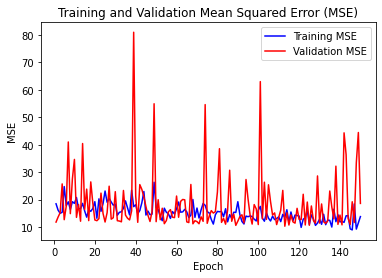

[*********************100%%**********************]  1 of 1 completed
51/51 [==============================] - 0s 3ms/step


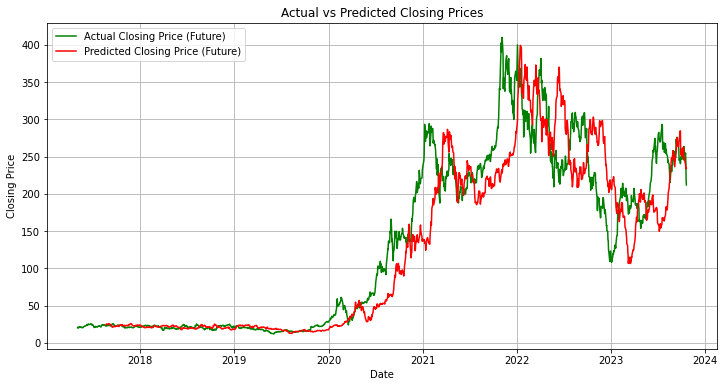

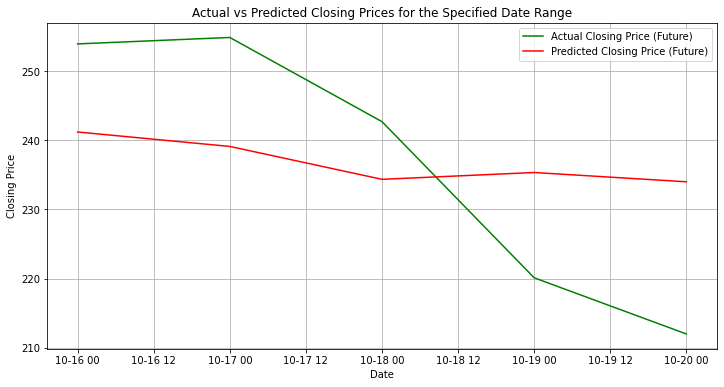

Data for the Last Plot:
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-10-16  250.050003  255.399994  248.479996  253.919998  253.919998   
2023-10-17  250.100006  257.179993  247.080002  254.850006  254.850006   
2023-10-18  252.699997  254.630005  242.080002  242.679993  242.679993   
2023-10-19  225.949997  230.610001  216.779999  220.110001  220.110001   
2023-10-20  217.009995  218.860001  210.419998  211.990005  211.990005   

               Volume      Tenkan       Kijun    Senkou A    Senkou B  \
Date                                                                    
2023-10-16   88917200  268.940002  278.980011  286.095001  245.670006   
2023-10-17   93562900  268.940002  278.980011  286.095001  245.670006   
2023-10-18  125147800  268.940002  278.980011  286.095001  245.670006   
2023-10-19  170772700  268.940002  278.980011  284.210007  245.670006   
2023-10-20  1377340

In [133]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Download historical data for the stock (e.g., TSLA)
ticker = "TSLA"
data = yf.download(ticker, period="80mo", interval="1d")

# Calculate Ichimoku components
tenkan_period = 9
kijun_period = 26
senkou_period = 52

data['Tenkan'] = data['High'].rolling(window=tenkan_period).max()
data['Kijun'] = data['High'].rolling(window=kijun_period).max()

data['Senkou A'] = ((data['Tenkan'] + data['Kijun']) / 2).shift(senkou_period)
data['Senkou B'] = (data['High'].rolling(window=senkou_period).max() + data['Low'].rolling(window=senkou_period).min()) / 2

# Calculate additional indicators
ma_period = 20
data['MA'] = data['Close'].rolling(ma_period).mean()

# Calculate RSI without using talib
rsi_period = 14
delta = data['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
average_gain = gain.rolling(window=rsi_period).mean()
average_loss = loss.rolling(window=rsi_period).mean()
rs = average_gain / average_loss
data['RSI'] = 100 - (100 / (1 + rs))

# Define the date range for the current week
current_date = datetime.now()
start_of_week = current_date - timedelta(days=current_date.weekday())
end_of_week = start_of_week + timedelta(days=6)

# Filter data for the current week
data_current_week = data[(data.index >= start_of_week) & (data.index <= end_of_week)]

# Create images from the data
image_width = 50  # Should match your training window size
image_height = 12  # Number of technical indicators

# Create an empty array to store the images
images = []

# Normalize your data for better visualization (scaling to the [0, 1] range)
normalized_data = (data - data.min()) / (data.max() - data.min())

# Loop through the data and create images
for i in range(image_width, len(data)):
    image = normalized_data.iloc[i - image_width:i].values
    images.append(image)

# Convert the images list to a NumPy array
X = np.array(images)

# Make predictions using your trained model
predicted_closing_prices = model.predict(X)  # X is your input data

# Plot actual and predicted closing prices
plt.figure(figsize=(12, 6))
plt.plot(data.index[-len(predicted_closing_prices):], data['Close'].tail(len(predicted_closing_prices)), label='Actual Closing Price (Future)', color='green')
plt.plot(data.index[-len(predicted_closing_prices):], predicted_closing_prices, label='Predicted Closing Price (Future)', color='red')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Actual vs Predicted Closing Prices')
plt.legend()
plt.grid()

# Filter data for the specific date range
start_date = '2023-10-16'
end_date = '2023-10-20'
data_filtered = data[(data.index >= start_date) & (data.index <= end_date)]

# Trim predicted_closing_prices to match the length of data_filtered
predicted_closing_prices = predicted_closing_prices[-len(data_filtered):]

# Create a plot for the filtered data
plt.figure(figsize=(12, 6))
plt.plot(data_filtered.index.to_numpy(), data_filtered['Close'], label='Actual Closing Price (Future)', color='green')
plt.plot(data_filtered.index.to_numpy(), predicted_closing_prices.flatten(), label='Predicted Closing Price (Future)', color='red')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Actual vs Predicted Closing Prices for the Specified Date Range')
plt.legend()
plt.grid()
plt.show()

# Print the data for the last plot
print("Data for the Last Plot:")
print(data_filtered)


In [17]:
import numpy as np
import pandas as pd
import yfinance as yf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import matplotlib.pyplot as plt

# Download stock data
ticker = "TSLA"
data = yf.download(ticker, period="80mo", interval="1d")

# Calculate Ichimoku components
tenkan_period = 9
kijun_period = 26
senkou_period = 52

data['Tenkan'] = data['High'].rolling(window=tenkan_period).max()
data['Kijun'] = data['High'].rolling(window=kijun_period).max()

data['Senkou A'] = ((data['Tenkan'] + data['Kijun']) / 2).shift(senkou_period)
data['Senkou B'] = (data['High'].rolling(window=senkou_period).max() + data['Low'].rolling(window=senkou_period).min()) / 2

# Calculate additional indicators
ma_period = 20
data['MA'] = data['Close'].rolling(ma_period).mean()

# Calculate RSI without using talib
rsi_period = 14
delta = data['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
average_gain = gain.rolling(window=rsi_period).mean()
average_loss = loss.rolling(window=rsi_period).mean()
rs = average_gain / average_loss
data['RSI'] = 100 - (100 / (1 + rs))

# Check the NAs before filling
na_count_before = data.isna().sum()
print("NAs count before filling:")
print(na_count_before)

# Backward-fill NAs
data.fillna(method='bfill', inplace=True)

# Check the NAs count after filling
na_count_after = data.isna().sum()
print("NAs count after filling:")
print(na_count_after)

print("Number of samples before generating images:", len(data))

# Define target date
target_date = "2023-10-23"

# Split data
train = data[:target_date]
test = data[target_date:]

# Create images from the data
image_width = 50  # Corresponding to your time window
image_height = 12  # Number of technical indicators

# Create an empty array to store the images
images = []

# Normalize your data for better visualization (scaling to the [0, 1] range)
normalized_data = (data - data.min()) / (data.max() - data.min())

# Loop through the data and create images
for i in range(image_width, len(data)):
    image = normalized_data.iloc[i - image_width:i].values
    images.append(image)

# Convert the images list to a NumPy array
X = np.array(images)

# Define the target variable
y_train = train['Close'].shift(-1).dropna().values
y_test = test['Close'].shift(-1).dropna().values

# Ensure X and y have the same length
min_length = min(len(X), len(y_train))
X = X[:min_length]
y_train = y_train[:min_length]

# Train model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(image_width, image_height, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='adam')
model.fit(X, y_train, epochs=100)

# Make prediction
pred = model.predict(X)

# Reverse normalization
#min_val = data['Close'].min()
#max_val = data['Close'].max()
#pred = pred * (max_val - min_val) + min_val

# Predicted closing price for 10-23-2023
predicted_closing_price = pred[-1][0]
print("Predicted closing price for 10-23-2023:", predicted_closing_price)


[*********************100%%**********************]  1 of 1 completed
NAs count before filling:
Open          0
High          0
Low           0
Close         0
Adj Close     0
Volume        0
Tenkan        8
Kijun        25
Senkou A     77
Senkou B     51
MA           19
RSI          13
dtype: int64
NAs count after filling:
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Tenkan       0
Kijun        0
Senkou A     0
Senkou B     0
MA           0
RSI          0
dtype: int64
Number of samples before generating images: 1679
Epoch 1/100


C:\Users\beaud\AppData\Local\Temp\ipykernel_19068\2578030846.py:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)


51/51 [==============================] - 1s 8ms/step - loss: 15558.7480
Epoch 2/100
51/51 [==============================] - 0s 8ms/step - loss: 710.3076
Epoch 3/100
51/51 [==============================] - 0s 7ms/step - loss: 448.8388
Epoch 4/100
51/51 [==============================] - 0s 8ms/step - loss: 383.9934
Epoch 5/100
51/51 [==============================] - 0s 8ms/step - loss: 314.5452
Epoch 6/100
51/51 [==============================] - 0s 7ms/step - loss: 258.0692
Epoch 7/100
51/51 [==============================] - 0s 8ms/step - loss: 221.3278
Epoch 8/100
51/51 [==============================] - 0s 7ms/step - loss: 187.5022
Epoch 9/100
51/51 [==============================] - 0s 7ms/step - loss: 168.1350
Epoch 10/100
51/51 [==============================] - 0s 8ms/step - loss: 141.1248
Epoch 11/100
51/51 [==============================] - 0s 7ms/step - loss: 129.3039
Epoch 12/100
51/51 [==============================] - 0s 8ms/step - loss: 119.7129
Epoch 13/100
51/51 [===

51/51 [==============================] - 0s 2ms/step
Predicted closing price for 10-23-2023: 94807.305


In [18]:
# Make prediction
pred = model.predict(X)

# Predicted closing price for 10-23-2023
predicted_closing_price = pred[-1][0]
print("Predicted closing price for 10-23-2023:", predicted_closing_price)

51/51 [==============================] - 0s 2ms/step
Predicted closing price for 10-23-2023: 238.15619


[*********************100%%**********************]  1 of 1 completed
NAs count before filling:
Open          0
High          0
Low           0
Close         0
Adj Close     0
Volume        0
Tenkan        3
Kijun        12
Senkou A     38
Senkou B     25
MA            9
RSI           6
dtype: int64
NAs count after filling:
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Tenkan       0
Kijun        0
Senkou A     0
Senkou B     0
MA           0
RSI          0
dtype: int64
Number of samples before generating images: 1679


C:\Users\beaud\AppData\Local\Temp\ipykernel_10192\2624012697.py:47: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Tenkan'].fillna(method='bfill', inplace=True)
C:\Users\beaud\AppData\Local\Temp\ipykernel_10192\2624012697.py:48: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Kijun'].fillna(method='bfill', inplace=True)
C:\Users\beaud\AppData\Local\Temp\ipykernel_10192\2624012697.py:49: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Senkou A'].fillna(method='bfill', inplace=True)
C:\Users\beaud\AppData\Local\Temp\ipykernel_10192\2624012697.py:50: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Senkou B'].fillna(method=

Length: 1629
Number of Images: 1629


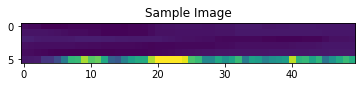

Number of Images: 1629
shapes (1126, 6, 50)
shapes2 (282, 6, 50)
Epoch 1/400
71/71 [==============================] - 1s 10ms/step - loss: 4006.8770
Epoch 2/400
71/71 [==============================] - 1s 9ms/step - loss: 296.1460
Epoch 3/400
71/71 [==============================] - 1s 10ms/step - loss: 229.4351
Epoch 4/400
71/71 [==============================] - 1s 10ms/step - loss: 272.3802
Epoch 5/400
71/71 [==============================] - 1s 9ms/step - loss: 216.7519
Epoch 6/400
71/71 [==============================] - 1s 10ms/step - loss: 223.8375
Epoch 7/400
71/71 [==============================] - 1s 9ms/step - loss: 212.4915
Epoch 8/400
71/71 [==============================] - 1s 10ms/step - loss: 158.2470
Epoch 9/400
71/71 [==============================] - 1s 9ms/step - loss: 131.5759
Epoch 10/400
71/71 [==============================] - 1s 9ms/step - loss: 131.2065
Epoch 11/400
71/71 [==============================] - 1s 10ms/step - loss: 118.5086
Epoch 12/400
71/71 [====

71/71 [==============================] - 1s 11ms/step - loss: 14.1877
Epoch 198/400
71/71 [==============================] - 1s 10ms/step - loss: 21.8692
Epoch 199/400
71/71 [==============================] - 1s 10ms/step - loss: 20.5620
Epoch 200/400
71/71 [==============================] - 1s 11ms/step - loss: 33.3074
Epoch 201/400
71/71 [==============================] - 1s 9ms/step - loss: 15.4148
Epoch 202/400
71/71 [==============================] - 1s 9ms/step - loss: 18.6380
Epoch 203/400
71/71 [==============================] - 1s 10ms/step - loss: 16.2137
Epoch 204/400
71/71 [==============================] - 1s 9ms/step - loss: 20.1341
Epoch 205/400
71/71 [==============================] - 1s 10ms/step - loss: 44.9187
Epoch 206/400
71/71 [==============================] - 1s 10ms/step - loss: 48.0656
Epoch 207/400
71/71 [==============================] - 1s 10ms/step - loss: 16.1671
Epoch 208/400
71/71 [==============================] - 1s 9ms/step - loss: 11.2383
Epoch 209/

71/71 [==============================] - 1s 9ms/step - loss: 10.1908
Epoch 395/400
71/71 [==============================] - 1s 11ms/step - loss: 3.7285
Epoch 396/400
71/71 [==============================] - 1s 9ms/step - loss: 5.6316
Epoch 397/400
71/71 [==============================] - 1s 10ms/step - loss: 34.6548
Epoch 398/400
71/71 [==============================] - 1s 10ms/step - loss: 10.3789
Epoch 399/400
71/71 [==============================] - 1s 9ms/step - loss: 8.0530
Epoch 400/400
9/9 [==============================] - 0s 4ms/step - loss: 19.8872
Mean Squared Error on Validation Set: 19.88724136352539


In [26]:
#improved images attempt
#predict tomorrow's closing price given the past 50 day image input.
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
# Download stock data
ticker = "TSLA"
data = yf.download(ticker, period="80mo", interval="1d")

# Calculate Ichimoku components
tenkan_period = 4
kijun_period = 13
senkou_period = 26

data['Tenkan'] = data['High'].rolling(window=tenkan_period).max()
data['Kijun'] = data['High'].rolling(window=kijun_period).max()

data['Senkou A'] = ((data['Tenkan'] + data['Kijun']) / 2).shift(senkou_period)
data['Senkou B'] = (data['High'].rolling(window=senkou_period).max() + data['Low'].rolling(window=senkou_period).min()) / 2

# Calculate additional indicators
ma_period = 10
data['MA'] = data['Close'].rolling(ma_period).mean()

# Calculate RSI without using talib
rsi_period = 7
delta = data['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
average_gain = gain.rolling(window=rsi_period).mean()
average_loss = loss.rolling(window=rsi_period).mean()
rs = average_gain / average_loss
data['RSI'] = 100 - (100 / (1 + rs))

# Check the NAs before filling
na_count_before = data.isna().sum()
print("NAs count before filling:")
print(na_count_before)

# Backward-fill NAs
data['Tenkan'].fillna(method='bfill', inplace=True)
data['Kijun'].fillna(method='bfill', inplace=True)
data['Senkou A'].fillna(method='bfill', inplace=True)
data['Senkou B'].fillna(method='bfill', inplace=True)
data['MA'].fillna(method='bfill', inplace=True)
data['RSI'].fillna(method='bfill', inplace=True)

# Check the NAs count after filling
na_count_after = data.isna().sum()
print("NAs count after filling:")
print(na_count_after)

print("Number of samples before generating images:", len(data))

# Define target date
target_date = "2022-10-01"  # Adjust to a suitable date in the middle of your dataset


# Split data
train = data[:target_date]
test = data[target_date:]

# Create images from the data
image_width = 50  # Corresponding to your time window
image_height = 12  # Number of technical indicators


# Modify image_width and image_height to match your data size
image_width = 50
image_height = len(data.columns)

# Create an empty array to store the images
images = []

# Normalize your data for better visualization (scaling to the [0, 1] range)
normalized_data = (data - data.min()) / (data.max() - data.min())

# Loop through the data and create images
for i in range(image_width, len(data)):
    # Create a multi-channel image
    raw_prices = normalized_data['Close'].iloc[i - image_width:i].values
    ichimoku_lines = np.array([
        normalized_data['Tenkan'].iloc[i - image_width:i],
        normalized_data['Kijun'].iloc[i - image_width:i],
        normalized_data['Senkou A'].iloc[i - image_width:i],
        normalized_data['Senkou B'].iloc[i - image_width:i]
    ])
    additional_indicators = np.array([
        normalized_data['MA'].iloc[i - image_width:i],
        normalized_data['RSI'].iloc[i - image_width:i]
    ])
    heatmap = np.vstack([ichimoku_lines, additional_indicators])
    multi_channel_image = heatmap #raw prices not used (improved results)

    images.append(multi_channel_image)
print("Length:",len(images))
# Convert the images list to a NumPy array
X = np.array(images)

import random
# Ensure images are generated correctly
print("Number of Images:", X.shape[0])  # Print the number of images
# Plot a random sample image
sample_index = random.randint(0, len(X) - 1)  # Choose a random index
sample_image = X[sample_index, :, :]
plt.imshow(sample_image, cmap='viridis')  # Adjust the colormap as needed
plt.title("Sample Image")
plt.show()

# Count the number of images
num_images = X.shape[0]
print("Number of Images:", num_images)


# Define the target variable 
y_train = train['Close'].shift(-1).dropna().values
y_test = test['Close'].shift(-1).dropna().values

# Ensure X and y have the same length
min_length = min(len(X), len(y_train))  # Corrected line
X = X[:min_length]
y_train = y_train[:min_length]


# Train test split
X_train, X_val, y_train, y_val = train_test_split(X, y_train, test_size=0.2)  # Adjust the test size as needed
print("shapes",X_train.shape)
print("shapes2",X_val.shape)
#X_train = X_train.reshape(X_train.shape[0], image_width, image_height, 1)
#X_val = X_val.reshape(X_val.shape[0], image_width, image_height, 1)

# Define model for regression
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(6, 50, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, epochs=400, batch_size=16, verbose=1)

# Evaluate the model on the validation set
mse = model.evaluate(X_val, y_val)
print("Mean Squared Error on Validation Set:", mse)


[*********************100%%**********************]  1 of 1 completed
NAs count before filling:
Open           0
High           0
Low            0
Close          0
Adj Close      0
Volume         0
Tenkan         3
Kijun         12
Senkou A      38
Senkou B      25
UpperBand     19
LowerBand     19
MACD           0
SignalLine     0
MA             9
RSI            6
dtype: int64
NAs count after filling:
Open          0
High          0
Low           0
Close         0
Adj Close     0
Volume        0
Tenkan        0
Kijun         0
Senkou A      0
Senkou B      0
UpperBand     0
LowerBand     0
MACD          0
SignalLine    0
MA            0
RSI           0
dtype: int64
Number of samples before generating images: 2100


C:\Users\beaud\AppData\Local\Temp\ipykernel_12608\2326867119.py:76: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Tenkan'].fillna(method='bfill', inplace=True)
C:\Users\beaud\AppData\Local\Temp\ipykernel_12608\2326867119.py:77: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Kijun'].fillna(method='bfill', inplace=True)
C:\Users\beaud\AppData\Local\Temp\ipykernel_12608\2326867119.py:78: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Senkou A'].fillna(method='bfill', inplace=True)
C:\Users\beaud\AppData\Local\Temp\ipykernel_12608\2326867119.py:79: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Senkou B'].fillna(method=

Length: 2075
Number of Images: 2075


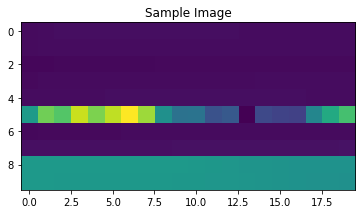

Number of Images: 2075
shapes (1660, 10, 20)
shapes2 (415, 10, 20)
Minimum values during training:
Open          2.250000e+01
High          2.291750e+01
Low           2.236750e+01
Close         2.258500e+01
Adj Close     2.082606e+01
Volume        3.145820e+07
Tenkan        2.339250e+01
Kijun         2.397500e+01
Senkou A      2.382500e+01
Senkou B      2.377500e+01
UpperBand     2.448014e+01
LowerBand     2.126893e+01
MACD         -6.673117e+00
SignalLine   -5.815683e+00
MA            2.317750e+01
RSI           0.000000e+00
dtype: float64

Maximum values during training:
Open          1.962400e+02
High          1.982300e+02
Low           1.952800e+02
Close         1.964500e+02
Adj Close     1.961851e+02
Volume        6.488252e+08
Tenkan        1.982300e+02
Kijun         1.982300e+02
Senkou A      1.982300e+02
Senkou B      1.924150e+02
UpperBand     2.035871e+02
LowerBand     1.880877e+02
MACD          7.511570e+00
SignalLine    6.895524e+00
MA            1.942150e+02
RSI           1.

Epoch 150/400
104/104 [==============================] - 1s 5ms/step - loss: 3.2850 - val_loss: 2.9366
Epoch 151/400
104/104 [==============================] - 1s 6ms/step - loss: 3.1241 - val_loss: 2.8616
Epoch 152/400
104/104 [==============================] - 1s 6ms/step - loss: 3.3210 - val_loss: 2.8967
Epoch 153/400
104/104 [==============================] - 1s 6ms/step - loss: 3.1592 - val_loss: 3.0599
Epoch 154/400
104/104 [==============================] - 1s 6ms/step - loss: 3.0461 - val_loss: 2.8399
Epoch 155/400
104/104 [==============================] - 1s 5ms/step - loss: 3.1147 - val_loss: 3.4892
Epoch 156/400
104/104 [==============================] - 1s 7ms/step - loss: 3.1779 - val_loss: 2.8062
Epoch 157/400
104/104 [==============================] - 1s 6ms/step - loss: 3.1205 - val_loss: 3.2542
Epoch 158/400
104/104 [==============================] - 1s 5ms/step - loss: 3.1767 - val_loss: 3.0587
Epoch 159/400
104/104 [==============================] - 1s 6ms/step - lo

In [ ]:
#more indicators and data
#predict tomorrow's closing price given the past 7 day image input. (slow on day 2 day)
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from keras.optimizers import Adam

# Download stock data
ticker = "AAPL"
data = yf.download(ticker, period="100mo", interval="1d")

# Calculate Ichimoku components
tenkan_period = 4
kijun_period = 13
senkou_period = 26

data['Tenkan'] = data['High'].rolling(window=tenkan_period).max()
data['Kijun'] = data['High'].rolling(window=kijun_period).max()

data['Senkou A'] = ((data['Tenkan'] + data['Kijun']) / 2).shift(senkou_period)
data['Senkou B'] = (data['High'].rolling(window=senkou_period).max() + data['Low'].rolling(window=senkou_period).min()) / 2

# Calculate Bollinger Bands 
period = 20
stdev = 2

RollingMean = data['Close'].rolling(window=period).mean()
RollingStd = data['Close'].rolling(window=period).std()

UpperBand = RollingMean + (RollingStd * stdev)
LowerBand = RollingMean - (RollingStd * stdev)

data['UpperBand'] = UpperBand
data['LowerBand'] = LowerBand

# Calculate MACD
short_window = 12
long_window = 26
macd_signal = 9

ShortEMA = data['Close'].ewm(span=short_window, adjust=False).mean()
LongEMA = data['Close'].ewm(span=long_window, adjust=False).mean()

MACD = ShortEMA - LongEMA
SignalLine = MACD.ewm(span=macd_signal, adjust=False).mean()

data['MACD'] = MACD
data['SignalLine'] = SignalLine

# Calculate additional indicators
ma_period = 10
data['MA'] = data['Close'].rolling(ma_period).mean()

# Calculate RSI without using talib
rsi_period = 7
delta = data['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
average_gain = gain.rolling(window=rsi_period).mean()
average_loss = loss.rolling(window=rsi_period).mean()
rs = average_gain / average_loss
data['RSI'] = 100 - (100 / (1 + rs))

# Check the NAs before filling
na_count_before = data.isna().sum()
print("NAs count before filling:")
print(na_count_before)

# Backward-fill NAs
data['Tenkan'].fillna(method='bfill', inplace=True)
data['Kijun'].fillna(method='bfill', inplace=True)
data['Senkou A'].fillna(method='bfill', inplace=True)
data['Senkou B'].fillna(method='bfill', inplace=True)
data['MA'].fillna(method='bfill', inplace=True)
data['RSI'].fillna(method='bfill', inplace=True)
data['UpperBand'].fillna(method='bfill', inplace=True)
data['LowerBand'].fillna(method='bfill', inplace=True)
# Check the NAs count after filling
na_count_after = data.isna().sum()
print("NAs count after filling:")
print(na_count_after)

print("Number of samples before generating images:", len(data))

# Define target date
target_date = "2023-11-01"  # divide by date if wanted (otherwise use today)

# Split data
train = data[:target_date]
test = data[target_date:]

# Create images from the data
# Modify image_width and image_height to match your data size
image_width = 20
image_height = len(data.columns)


# Normalize your training data for better visualization (scaling to the [0, 1] range)
train_min = train.min()
train_max = train.max()

normalized_train = (train - train_min) / (train_max - train_min)

# Loop through the data and create images
images = []
for i in range(image_width, len(train)):
    # Create a multi-channel image
    raw_prices = normalized_train['Close'].iloc[i - image_width:i].values
    ichimoku_lines = np.array([
        normalized_train['Tenkan'].iloc[i - image_width:i],
        normalized_train['Kijun'].iloc[i - image_width:i],
        normalized_train['Senkou A'].iloc[i - image_width:i],
        normalized_train['Senkou B'].iloc[i - image_width:i]
    ])
    additional_indicators = np.array([
        normalized_train['MA'].iloc[i - image_width:i],
        normalized_train['RSI'].iloc[i - image_width:i]
    ])
    bbands = np.array([
        normalized_train['UpperBand'].iloc[i-image_width:i],
        normalized_train['LowerBand'].iloc[i-image_width:i]
    ])

    macd = np.array([
        normalized_train['MACD'].iloc[i-image_width:i],
        normalized_train['SignalLine'].iloc[i-image_width:i]  
    ])

    heatmap = np.vstack([ichimoku_lines, additional_indicators, bbands, macd])
    multi_channel_image = heatmap #raw prices not used (improved results)
    images.append(multi_channel_image)

print("Length:",len(images))
# Convert the images list to a NumPy array
X = np.array(images)

import random
# Ensure images are generated correctly
print("Number of Images:", X.shape[0])  # Print the number of images
# Plot a random sample image
sample_index = random.randint(0, len(X) - 1)  # Choose a random index
sample_image = X[sample_index, :, :]
plt.imshow(sample_image, cmap='viridis')  # Adjust the colormap as needed
plt.title("Sample Image")
plt.show()

# Count the number of images
num_images = X.shape[0]
print("Number of Images:", num_images)


# Define the target variable 
y_train = train['Close'].shift(-1).dropna().values
y_test = test['Close'].shift(-1).dropna().values

# Ensure X and y have the same length
min_length = min(len(X), len(y_train))  # Corrected line
X = X[:min_length]
y_train = y_train[:min_length]


# Train test split
X_train, X_val, y_train, y_val = train_test_split(X, y_train, test_size=0.2)  # Adjust the test size as needed
print("shapes",X_train.shape)
print("shapes2",X_val.shape)
#X_train = X_train.reshape(X_train.shape[0], image_width, image_height, 1)
#X_val = X_val.reshape(X_val.shape[0], image_width, image_height, 1)

print("Minimum values during training:")
print(train_min)
print("\nMaximum values during training:")
print(train_max)

# Define model for regression
model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(10, 20, 1)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))

model.save_weights('model_weights.h5')
# Set a lower learning rate
learning_rate = 0.0001  # You can adjust this value; lower for m2m

# Initialize the optimizer with the desired learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compile the model with the optimizer
model.compile(optimizer=optimizer, loss='mse')

history=model.fit(X_train, y_train, 
                    epochs=400, 
                    batch_size=16,
                    validation_data=(X_val, y_val), 
                    verbose=1)

# Evaluate the model on the validation set
mse = model.evaluate(X_val, y_val)
print("Mean Squared Error on Validation Set:", mse)

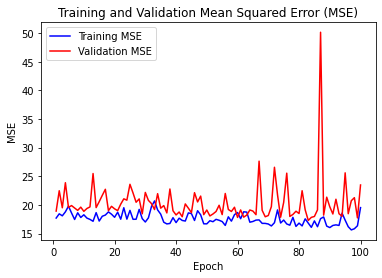

In [5]:
import matplotlib.pyplot as plt

history = model.fit(X_train, y_train, 
                    epochs=100, 
                    batch_size=16,
                    validation_data=(X_val, y_val), 
                    verbose=0)


# Access the MSE values from the history
train_mse = history.history['loss']
val_mse = history.history['val_loss']

# Plot both training and validation MSE
plt.plot(range(1, len(train_mse) + 1), train_mse, label='Training MSE', color='blue')
plt.plot(range(1, len(val_mse) + 1), val_mse, label='Validation MSE', color='red')
plt.title('Training and Validation Mean Squared Error (MSE)')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

[*********************100%%**********************]  1 of 1 completed
NAs count before filling:
Open          0
High          0
Low           0
Close         0
Adj Close     0
Volume        0
Tenkan        0
Kijun         0
Senkou A      0
Senkou B      0
UpperBand     0
LowerBand     0
MACD          0
SignalLine    0
MA            0
RSI           0
dtype: int64
NAs count after filling:
Open          0
High          0
Low           0
Close         0
Adj Close     0
Volume        0
Tenkan        0
Kijun         0
Senkou A      0
Senkou B      0
UpperBand     0
LowerBand     0
MACD          0
SignalLine    0
MA            0
RSI           0
dtype: int64
Number of samples before generating images: 2711


C:\Users\beaud\AppData\Local\Temp\ipykernel_7740\2825383127.py:69: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  new_data['Tenkan'].fillna(method='bfill', inplace=True)
C:\Users\beaud\AppData\Local\Temp\ipykernel_7740\2825383127.py:70: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  new_data['Kijun'].fillna(method='bfill', inplace=True)
C:\Users\beaud\AppData\Local\Temp\ipykernel_7740\2825383127.py:71: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  new_data['Senkou A'].fillna(method='bfill', inplace=True)
C:\Users\beaud\AppData\Local\Temp\ipykernel_7740\2825383127.py:72: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  new_data['Senkou B'].fi

Shape of X_new: (2691, 10, 20, 1)
85/85 [==============================] - 0s 2ms/step
Latest Predicted Closing Price: 205.62466
Date for the latest prediction: 2023-11-01 15:59:00-04:00


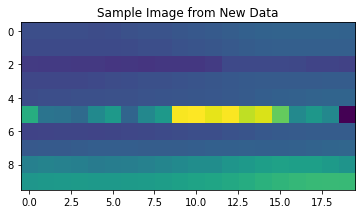

In [112]:
#prediction code
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import random
from tensorflow.keras.models import load_model

# Download new stock data
ticker = "TSLA"
new_data = yf.download(ticker, period="7d", interval="1m")

# Calculate Ichimoku components
tenkan_period = 4
kijun_period = 13
senkou_period = 26

new_data['Tenkan'] = new_data['High'].rolling(window=tenkan_period).max()
new_data['Kijun'] = new_data['High'].rolling(window=kijun_period).max()

new_data['Senkou A'] = ((new_data['Tenkan'] + new_data['Kijun']) / 2).shift(senkou_period)
new_data['Senkou B'] = (new_data['High'].rolling(window=senkou_period).max() + new_data['Low'].rolling(window=senkou_period).min()) / 2

# Calculate Bollinger Bands 
period = 20
stdev = 2

RollingMean = new_data['Close'].rolling(window=period).mean()
RollingStd = new_data['Close'].rolling(window=period).std()

UpperBand = RollingMean + (RollingStd * stdev)
LowerBand = RollingMean - (RollingStd * stdev)

new_data['UpperBand'] = UpperBand
new_data['LowerBand'] = LowerBand

# Calculate MACD
short_window = 12
long_window = 26
macd_signal = 9

ShortEMA = new_data['Close'].ewm(span=short_window, adjust=False).mean()
LongEMA = new_data['Close'].ewm(span=long_window, adjust=False).mean()

MACD = ShortEMA - LongEMA
SignalLine = MACD.ewm(span=macd_signal, adjust=False).mean()

new_data['MACD'] = MACD
new_data['SignalLine'] = SignalLine

# Calculate additional indicators
ma_period = 10
new_data['MA'] = new_data['Close'].rolling(ma_period).mean()

# Calculate RSI without using talib
rsi_period = 7
delta = new_data['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
average_gain = gain.rolling(window=rsi_period).mean()
average_loss = loss.rolling(window=rsi_period).mean()
rs = average_gain / average_loss
new_data['RSI'] = 100 - (100 / (1 + rs))

# Check the NAs before filling
na_count_before = data.isna().sum()
print("NAs count before filling:")
print(na_count_before)

# Backward-fill NAs
new_data['Tenkan'].fillna(method='bfill', inplace=True)
new_data['Kijun'].fillna(method='bfill', inplace=True)
new_data['Senkou A'].fillna(method='bfill', inplace=True)
new_data['Senkou B'].fillna(method='bfill', inplace=True)
new_data['MA'].fillna(method='bfill', inplace=True)
new_data['RSI'].fillna(method='bfill', inplace=True)
new_data['UpperBand'].fillna(method='bfill', inplace=True)
new_data['LowerBand'].fillna(method='bfill', inplace=True)
# Check the NAs count after filling
na_count_after = data.isna().sum()
print("NAs count after filling:")
print(na_count_after)

print("Number of samples before generating images:", len(data))

# Normalize your new data (Make sure to use the same scaling as in training)
normalized_new_data = (new_data - new_data.min()) / (new_data.max() - new_data.min())

# Create images from the new data (same process as in training)
image_width = 20
image_height = len(new_data.columns)
new_images = []

# Loop through the data and create images
for i in range(image_width, len(new_data)):
    # Create a multi-channel image
    raw_prices = normalized_new_data['Close'].iloc[i - image_width:i].values
    ichimoku_lines = np.array([
        normalized_new_data['Tenkan'].iloc[i - image_width:i],
        normalized_new_data['Kijun'].iloc[i - image_width:i],
        normalized_new_data['Senkou A'].iloc[i - image_width:i],
        normalized_new_data['Senkou B'].iloc[i - image_width:i]
    ])
    additional_indicators = np.array([
        normalized_new_data['MA'].iloc[i - image_width:i],
        normalized_new_data['RSI'].iloc[i - image_width:i]
    ])
    bbands = np.array([
        normalized_new_data['UpperBand'].iloc[i-image_width:i],
        normalized_data['LowerBand'].iloc[i-image_width:i]
    ])

    macd = np.array([
        normalized_new_data['MACD'].iloc[i-image_width:i],
        normalized_new_data['SignalLine'].iloc[i-image_width:i]  
    ])

    heatmap = np.vstack([ichimoku_lines, additional_indicators, bbands, macd])
    multi_channel_image = heatmap #raw prices not used (improved results)
    new_images.append(multi_channel_image)

# Convert the new images list to a NumPy array
X_new = np.array(new_images)

# Ensure the input shape is correct
X_new = X_new.reshape(-1, 10, 20, 1)

# Make predictions
print("Shape of X_new:", X_new.shape)
predicted_closing_prices = model.predict(X_new)

# Print the latest or final predicted closing price
latest_predicted_price = predicted_closing_prices[-1][0]
print("Latest Predicted Closing Price:", latest_predicted_price)
print("Date for the latest prediction:", new_data.index[-1])
# Optionally, visualize a random sample from the new data
sample_index = random.randint(0, len(X_new) - 1)
sample_image = X_new[sample_index, :, :, 0]
plt.imshow(sample_image, cmap='viridis')
plt.title("Sample Image from New Data")
plt.show()


[*********************100%%**********************]  1 of 1 completed
New data shape: (251, 6)
Indicators calculated
Data with indicators:
                 Tenkan       Kijun    Senkou A    Senkou B   UpperBand  \
Date                                                                     
2023-11-02  219.199997  257.179993  268.385010  231.505005  280.308731   
2023-11-03  226.369995  254.630005  264.265007  231.505005  276.447333   
2023-11-06  226.369995  230.610001  266.875008  231.505005  272.296280   
2023-11-07  226.369995  226.369995  266.875008  231.505005  266.809174   
2023-11-08  226.369995  226.369995  266.875008  231.505005  260.715475   

             LowerBand       MACD  SignalLine          MA        RSI  
Date                                                                  
2023-11-02  181.371268 -12.652806  -11.019541  208.844000  52.293143  
2023-11-03  181.175666 -11.397442  -11.095121  209.641000  59.253810  
2023-11-06  181.286718 -10.339052  -10.943907  210.360001 

C:\Users\beaud\AppData\Local\Temp\ipykernel_11168\3190966042.py:102: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  new_data.fillna(method='bfill', inplace=True)


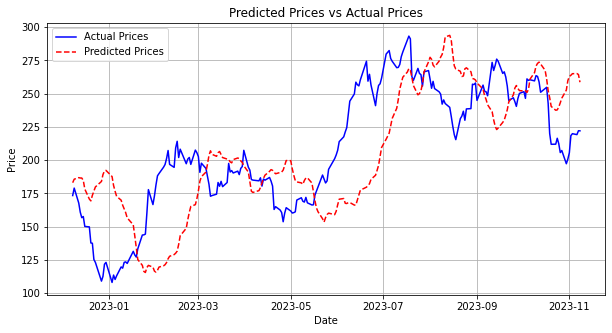

In [36]:
#predict and plot
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import yfinance as yf

# Function to update indicators with new predicted price
def update_indicators(new_data, predicted_price):
    new_entry = new_data.iloc[-1].copy()
    new_entry.name += pd.Timedelta(minutes=1)
    new_entry['Close'] = predicted_price

    updated_data = new_data.append(new_entry)
    
    # Update your indicators here
    updated_data['Tenkan'] = updated_data['High'].rolling(window=tenkan_period).max()
    updated_data['Kijun'] = updated_data['High'].rolling(window=kijun_period).max()
    updated_data['Senkou A'] = ((updated_data['Tenkan'] + updated_data['Kijun']) / 2).shift(senkou_period)
    updated_data['Senkou B'] = (updated_data['High'].rolling(window=senkou_period).max() + updated_data['Low'].rolling(window=senkou_period).min()) / 2

    RollingMean = updated_data['Close'].rolling(window=period).mean()
    RollingStd = updated_data['Close'].rolling(window=period).std()
    updated_data['UpperBand'] = RollingMean + (RollingStd * stdev)
    updated_data['LowerBand'] = RollingMean - (RollingStd * stdev)

    ShortEMA = updated_data['Close'].ewm(span=short_window, adjust=False).mean()
    LongEMA = updated_data['Close'].ewm(span=long_window, adjust=False).mean()
    MACD = ShortEMA - LongEMA
    SignalLine = MACD.ewm(span=macd_signal, adjust=False).mean()
    updated_data['MACD'] = MACD
    updated_data['SignalLine'] = SignalLine

    updated_data['MA'] = updated_data['Close'].rolling(ma_period).mean()
    
    delta = updated_data['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    average_gain = gain.rolling(window=rsi_period).mean()
    average_loss = loss.rolling(window=rsi_period).mean()
    rs = average_gain / average_loss
    updated_data['RSI'] = 100 - (100 / (1 + rs))

    return updated_data

# Download new stock data
ticker = "TSLA"
new_data = yf.download(ticker, period="12mo", interval="1d")
print("New data shape:", new_data.shape)

# Calculate Ichimoku components
tenkan_period = 4
kijun_period = 13
senkou_period = 26

new_data['Tenkan'] = new_data['High'].rolling(window=tenkan_period).max()
new_data['Kijun'] = new_data['High'].rolling(window=kijun_period).max()

new_data['Senkou A'] = ((new_data['Tenkan'] + new_data['Kijun']) / 2).shift(senkou_period)
new_data['Senkou B'] = (new_data['High'].rolling(window=senkou_period).max() + new_data['Low'].rolling(window=senkou_period).min()) / 2

# Calculate Bollinger Bands 
period = 20
stdev = 2

RollingMean = new_data['Close'].rolling(window=period).mean()
RollingStd = new_data['Close'].rolling(window=period).std()

new_data['UpperBand'] = RollingMean + (RollingStd * stdev)
new_data['LowerBand'] = RollingMean - (RollingStd * stdev)

# Calculate MACD
short_window = 12
long_window = 26
macd_signal = 9

ShortEMA = new_data['Close'].ewm(span=short_window, adjust=False).mean()
LongEMA = new_data['Close'].ewm(span=long_window, adjust=False).mean()

MACD = ShortEMA - LongEMA
SignalLine = MACD.ewm(span=macd_signal, adjust=False).mean()

new_data['MACD'] = MACD
new_data['SignalLine'] = SignalLine

# Calculate additional indicators
ma_period = 10
new_data['MA'] = new_data['Close'].rolling(ma_period).mean()

# Calculate RSI without using talib
rsi_period = 7
delta = new_data['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
average_gain = gain.rolling(window=rsi_period).mean()
average_loss = loss.rolling(window=rsi_period).mean()
rs = average_gain / average_loss
new_data['RSI'] = 100 - (100 / (1 + rs))

# Backward-fill NAs
new_data.interpolate(limit=limit, limit_direction='forward', inplace=True)
new_data.fillna(method='bfill', inplace=True)
print("Indicators calculated")
print("Data with indicators:\n", new_data[['Tenkan', 'Kijun', 'Senkou A', 'Senkou B', 'UpperBand', 'LowerBand', 'MACD', 'SignalLine', 'MA', 'RSI']].tail())

# Normalize your new data (Make sure to use the same scaling as in training)
normalized_new_data = (new_data - train_min) / (train_max - train_min)
print("Normalized data head:\n", normalized_new_data.head())

# Create images from the new data (same process as in training)
image_width = 20
image_height = len(new_data.columns)
new_images = []

predicted_prices = []
actual_prices = []
dates = []

# Now you have all the dates, actual prices, and predicted prices
# Loop through the data and create images
for i in range(image_width, len(normalized_new_data)):
    # Create a multi-channel image
    raw_prices = normalized_new_data['Close'].iloc[i - image_width:i].values 
    ichimoku_lines = np.array([
        normalized_new_data['Tenkan'].iloc[i - image_width:i],
        normalized_new_data['Kijun'].iloc[i - image_width:i],
        normalized_new_data['Senkou A'].iloc[i - image_width:i],
        normalized_new_data['Senkou B'].iloc[i - image_width:i]
    ])
    additional_indicators = np.array([
        normalized_new_data['MA'].iloc[i - image_width:i],
        normalized_new_data['RSI'].iloc[i - image_width:i]
    ])
    bbands = np.array([
        normalized_new_data['UpperBand'].iloc[i-image_width:i],
        normalized_new_data['LowerBand'].iloc[i-image_width:i]
    ])

    macd = np.array([
        normalized_new_data['MACD'].iloc[i-image_width:i],
        normalized_new_data['SignalLine'].iloc[i-image_width:i]  
    ])

    heatmap = np.vstack([ichimoku_lines, additional_indicators, bbands, macd]) #raw prices not used (improves potential cheating)
    multi_channel_image = heatmap 
    new_images.append(multi_channel_image)
    actual_prices.append(new_data['Close'].iloc[i])  # Actual price is the current close
    dates.append(new_data.index[i])  # Append the date

print("Num of new images:", len(new_images))
# Convert 'new_images' to a NumPy array
X_new = np.array(new_images)    
print("Prediction Images Shape:", np.array(new_images).shape)
# Convert the image to a NumPy array and reshape for the model
X_new= X_new.reshape(-1, 10, 20, 1)
# Now, predict using the model
predicted_closing_price = model.predict(X_new)
# Append the predicted price, actual price, and date
predicted_prices = [pred[0] for pred in predicted_closing_price]
print("predictions len",len(predicted_prices))


# Display the last predicted price and corresponding date
if predicted_prices and dates:
    print("Last Predicted Closing Price:", predicted_prices[-1])
    print("Date for the last prediction:", dates[-1])
else:
    print("No predictions available.")

# Plotting Predicted Prices vs Actual Prices
plt.figure(figsize=(10, 5))
plt.plot(dates, actual_prices, label='Actual Prices', color='blue')
plt.plot(dates, predicted_prices, label='Predicted Prices', color='red', linestyle='dashed')
plt.title('Predicted Prices vs Actual Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

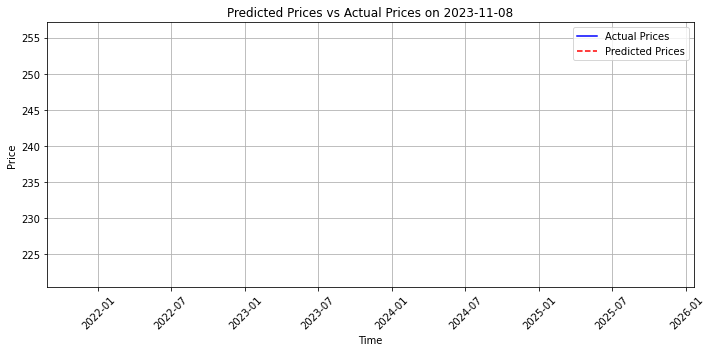

In [13]:
import datetime

# Choose the date for plotting (last day in the dataset)
plot_date = new_data.index[-1].date()  # This will choose the last date in the dataset

# You can also specify a specific date like this:
# plot_date = datetime.date(2023, 10, 27)  # Example date: October 27, 2023

# Filter the lists to include only entries for the chosen date
filtered_predicted_prices = [p for p, d in zip(predicted_prices, dates) if d.date() == plot_date]
filtered_actual_prices = [a for a, d in zip(actual_prices, dates) if d.date() == plot_date]
filtered_dates = [d for d in dates if d.date() == plot_date]

# Plotting Predicted Prices vs Actual Prices for the chosen date
plt.figure(figsize=(10, 5))
plt.plot(filtered_dates, filtered_actual_prices, label='Actual Prices', color='blue')
plt.plot(filtered_dates, filtered_predicted_prices, label='Predicted Prices', color='red', linestyle='dashed')
plt.title(f'Predicted Prices vs Actual Prices on {plot_date}')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjusts the plot to ensure everything fits without overlapping
plt.show()


In [57]:
import pandas as pd

# Assuming 'dates', 'predicted_prices', and 'actual_prices' are lists or Pandas Series containing the corresponding data
dates = pd.Series(dates)  # Convert to Pandas Series if it's not already one

# Convert to datetime if not already in that format
dates = pd.to_datetime(dates)

# Get the last month's worth of dates from your dates series
last_month_end = dates.iloc[-1]
last_month_start = last_month_end - pd.DateOffset(months=1)

# Find the indices that correspond to the last month
last_month_indices = dates[(dates >= last_month_start) & (dates <= last_month_end)].index

# Initialize counters for last month
correct_up_predictions_last_month = 0
correct_down_predictions_last_month = 0

# Loop over the last month's indices
for i in last_month_indices[1:]:  # Start from the second index because we compare with the previous
    predicted_change = predicted_prices[i] - predicted_prices[i - 1]
    actual_change = actual_prices[i] - actual_prices[i - 1]

    # Check if the prediction was correct
    if predicted_change > 0 and actual_change > 0:
        correct_up_predictions_last_month += 1
    elif predicted_change < 0 and actual_change < 0:
        correct_down_predictions_last_month += 1

# Calculate accuracy for the last month
total_correct_predictions_last_month = correct_up_predictions_last_month + correct_down_predictions_last_month
total_predictions_last_month = len(last_month_indices) - 1  # Minus 1 because we compare with the previous price
accuracy_last_month = (total_correct_predictions_last_month / total_predictions_last_month) * 100 if total_predictions_last_month else 0
print(f"Overall prediction accuracy for last month: {accuracy_last_month:.2f}%")

# Initialize counters for entire dataset
correct_up_predictions = 0
correct_down_predictions = 0

# Loop over all indices
for i in range(1, len(dates)):  # Start from the second index because we compare with the previous
    predicted_change = predicted_prices[i] - predicted_prices[i - 1]
    actual_change = actual_prices[i] - actual_prices[i - 1]

    # Check if the prediction was correct
    if predicted_change > 0 and actual_change > 0:
        correct_up_predictions += 1
    elif predicted_change < 0 and actual_change < 0:
        correct_down_predictions += 1

# Calculate accuracy for the entire dataset
total_correct_predictions = correct_up_predictions + correct_down_predictions
total_predictions = len(dates) - 1  # Minus 1 because we compare with the previous price
accuracy = (total_correct_predictions / total_predictions) * 100 if total_predictions else 0
print(f"Overall prediction accuracy: {accuracy:.2f}%")

Overall prediction accuracy for last month: 47.83%
Overall prediction accuracy: 50.89%


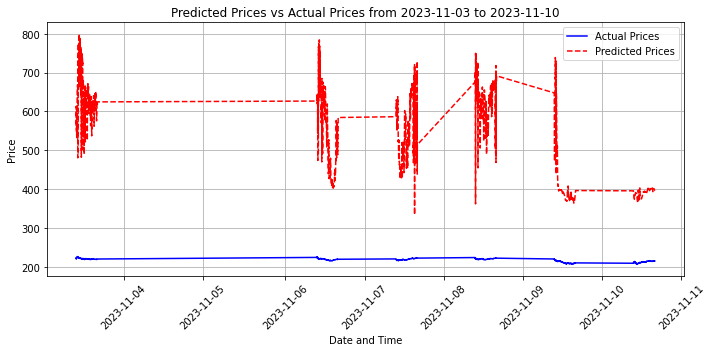

In [8]:
import datetime

# Choose the starting date for plotting (a week before the last date in the dataset)
start_date = new_data.index[-1].date() - datetime.timedelta(days=7)

# Filter the lists to include only entries within the week range
filtered_predicted_prices = [p for p, d in zip(predicted_prices, dates) if start_date <= d.date() <= new_data.index[-1].date()]
filtered_actual_prices = [a for a, d in zip(actual_prices, dates) if start_date <= d.date() <= new_data.index[-1].date()]
filtered_dates = [d for d in dates if start_date <= d.date() <= new_data.index[-1].date()]

# Plotting Predicted Prices vs Actual Prices for the week
plt.figure(figsize=(10, 5))
plt.plot(filtered_dates, filtered_actual_prices, label='Actual Prices', color='blue')
plt.plot(filtered_dates, filtered_predicted_prices, label='Predicted Prices', color='red', linestyle='dashed')
plt.title(f'Predicted Prices vs Actual Prices from {start_date} to {new_data.index[-1].date()}')
plt.xlabel('Date and Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjusts the plot to ensure everything fits without overlapping
plt.show()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
NAs count before filling:
Open           0
High           0
Low            0
Close          0
Adj Close      0
Volume         0
Tenkan         3
Kijun         12
Senkou A      38
Senkou B      25
UpperBand     19
LowerBand     19
MACD           0
SignalLine     0
MA             9
RSI           22
dtype: int64
NAs count after filling:
Open          0
High          0
Low           0
Close         0
Adj Close     0
Volume        0
Tenkan        0
Kijun         0
Senkou A      0
Senkou B      0
UpperBand     0
LowerBand     0
MACD          0
SignalLine    0
MA            0
RSI           0
dtype: int64
Number of samples before generating images: 8983
l

C:\Users\beaud\AppData\Local\Temp\ipykernel_692\2715847944.py:82: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  all_data.fillna(method='bfill', inplace=True)


Length: 8963
Number of Images: 8963


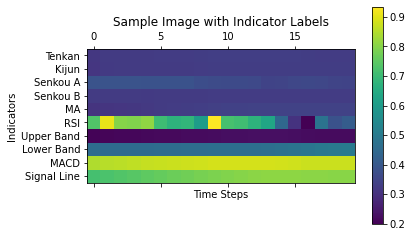

Number of Images: 8963
shapes (7170, 10, 20)
shapes2 (1793, 10, 20)
Minimum values during training:
Open            1.400000
High            1.440000
Low             1.330000
Close           1.330000
Adj Close       1.330000
Volume          0.000000
Tenkan          1.490000
Kijun           5.047500
Senkou A        5.040000
Senkou B        5.380000
UpperBand       5.400806
LowerBand    -245.124309
MACD         -215.728331
SignalLine    -98.444381
MA              4.923750
RSI             0.000000
dtype: float64

Maximum values during training:
Open          1.144000e+03
High          1.152180e+03
Low           1.130000e+03
Close         1.149060e+03
Adj Close     1.149060e+03
Volume        9.140820e+08
Tenkan        1.152180e+03
Kijun         1.152180e+03
Senkou A      1.015000e+03
Senkou B      1.063540e+03
UpperBand     1.753954e+03
LowerBand     9.749000e+02
MACD          3.806793e+01
SignalLine    3.281055e+01
MA            1.096706e+03
RSI           1.000000e+02
dtype: float64
Epoch

449/449 [==============================] - 1s 3ms/step - loss: 61.2831 - val_loss: 67.2942
Epoch 148/150
449/449 [==============================] - 1s 3ms/step - loss: 60.7335 - val_loss: 67.1120
Epoch 149/150
449/449 [==============================] - 1s 3ms/step - loss: 61.6468 - val_loss: 62.2757
Epoch 150/150
57/57 [==============================] - 0s 2ms/step - loss: 63.2910
Mean Squared Error on Validation Set: 63.290985107421875


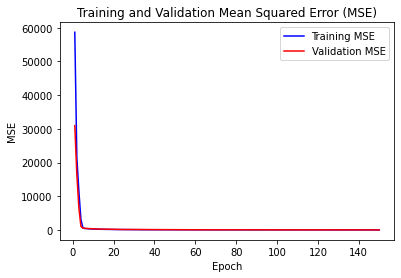

In [43]:
#train on multiple instead of 1
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from keras.optimizers import Adam

def download_and_process_stock_data(ticker):
    data = yf.download(ticker, period="100mo", interval="1d")
    return data

# Define tickers
tickers = ["TSLA","NVDA","GOOGL","ADBE","AMZ"]

# Download and process data for each ticker
all_data = pd.concat([download_and_process_stock_data(ticker) for ticker in tickers], keys=tickers)

# Calculate Ichimoku components
tenkan_period = 4
kijun_period = 13
senkou_period = 26

all_data['Tenkan'] = all_data['High'].rolling(window=tenkan_period).max()
all_data['Kijun'] = all_data['High'].rolling(window=kijun_period).max()

all_data['Senkou A'] = ((all_data['Tenkan'] + all_data['Kijun']) / 2).shift(senkou_period)
all_data['Senkou B'] = (all_data['High'].rolling(window=senkou_period).max() + all_data['Low'].rolling(window=senkou_period).min()) / 2

# Calculate Bollinger Bands 
period = 20
stdev = 2

RollingMean = all_data['Close'].rolling(window=period).mean()
RollingStd = all_data['Close'].rolling(window=period).std()

UpperBand = RollingMean + (RollingStd * stdev)
LowerBand = RollingMean - (RollingStd * stdev)

all_data['UpperBand'] = UpperBand
all_data['LowerBand'] = LowerBand

# Calculate MACD
short_window = 12
long_window = 26
macd_signal = 9

ShortEMA = all_data['Close'].ewm(span=short_window, adjust=False).mean()
LongEMA = all_data['Close'].ewm(span=long_window, adjust=False).mean()

MACD = ShortEMA - LongEMA
SignalLine = MACD.ewm(span=macd_signal, adjust=False).mean()

all_data['MACD'] = MACD
all_data['SignalLine'] = SignalLine

# Calculate additional indicators
ma_period = 10
all_data['MA'] = all_data['Close'].rolling(ma_period).mean()

# Calculate RSI without using talib
rsi_period = 7
delta = all_data['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
average_gain = gain.rolling(window=rsi_period).mean()
average_loss = loss.rolling(window=rsi_period).mean()
rs = average_gain / average_loss
all_data['RSI'] = 100 - (100 / (1 + rs))

# Check the NAs before filling
na_count_before = all_data.isna().sum()
print("NAs count before filling:")
print(na_count_before)

limit = 2
all_data.interpolate(limit=limit, limit_direction='forward', inplace=True)
all_data.fillna(method='bfill', inplace=True)

# Check the NAs count after filling
na_count_after = all_data.isna().sum()
print("NAs count after filling:")
print(na_count_after)

print("Number of samples before generating images:", len(all_data))

train = all_data  # Data up to use (no test set)

# Create images from the data
# Modify image_width and image_height to match your data size
image_width = 20
image_height = len(all_data.columns)


# Normalize your training data for better visualization (scaling to the [0, 1] range)
train_min = train.min()
train_max = train.max()

normalized_train = (train - train_min) / (train_max - train_min)
print("len normalized_train:", len(train))
# Loop through the data and create images
images = []
for i in range(image_width, len(train)):
    # Create a multi-channel image
    raw_prices = normalized_train['Close'].iloc[i - image_width:i].values 
    ichimoku_lines = np.array([
        normalized_train['Tenkan'].iloc[i - image_width:i],
        normalized_train['Kijun'].iloc[i - image_width:i],
        normalized_train['Senkou A'].iloc[i - image_width:i],
        normalized_train['Senkou B'].iloc[i - image_width:i]
    ])
    additional_indicators = np.array([
        normalized_train['MA'].iloc[i - image_width:i],
        normalized_train['RSI'].iloc[i - image_width:i]
    ])
    bbands = np.array([
        normalized_train['UpperBand'].iloc[i-image_width:i],
        normalized_train['LowerBand'].iloc[i-image_width:i]
    ])

    macd = np.array([
        normalized_train['MACD'].iloc[i-image_width:i],
        normalized_train['SignalLine'].iloc[i-image_width:i]  
    ])

    heatmap = np.vstack([ichimoku_lines, additional_indicators, bbands, macd]) #raw prices not used (improves potential cheating)
    multi_channel_image = heatmap 
    images.append(multi_channel_image)

print("Length:",len(images))
# Convert the images list to a NumPy array
X = np.array(images)

import random
# Ensure images are generated correctly
print("Number of Images:", X.shape[0])  # Print the number of images

# Plotting a random sample image
# Choose a random index for a sample image
sample_index = random.randint(0, len(images) - 1)
sample_image = images[sample_index]

# Plot the sample image
fig, ax = plt.subplots()
cax = ax.matshow(sample_image, cmap='viridis')

# Add color bar
plt.colorbar(cax)

# Define the labels for each row of the heatmap
labels = ["Tenkan", "Kijun", "Senkou A", "Senkou B", "MA", "RSI", "Upper Band", "Lower Band", "MACD", "Signal Line"]

# Set the tick marks and labels
ax.set_yticks(np.arange(len(labels)))
ax.set_yticklabels(labels)

# Set labels for the axes
plt.xlabel("Time Steps")
plt.ylabel("Indicators")

plt.title("Sample Image with Indicator Labels")
plt.show()

# Count the number of images
num_images = X.shape[0]
print("Number of Images:", num_images)


# Define the target variable 
y_train = train['Close'].shift(-1).dropna().values

# Ensure X and y have the same length
min_length = min(len(X), len(y_train))  # Corrected line
X = X[:min_length]
y_train = y_train[:min_length]

# Train test split
X_train, X_val, y_train, y_val = train_test_split(X, y_train, test_size=0.2)  # Adjust the test size as needed
print("shapes",X_train.shape)
print("shapes2",X_val.shape)
#X_train = X_train.reshape(X_train.shape[0], image_width, image_height, 1)
#X_val = X_val.reshape(X_val.shape[0], image_width, image_height, 1)

print("Minimum values during training:")
print(train_min)
print("\nMaximum values during training:")
print(train_max)

# Define model for regression
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(10, 20, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))

model.save_weights('model_weights.h5')
# Set a lower learning rate
learning_rate = 0.0001  # You can adjust this value; lower for m2m

# Initialize the optimizer with the desired learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compile the model with the optimizer
model.compile(optimizer=optimizer, loss='mse')

history=model.fit(X_train, y_train, 
                    epochs=150, 
                    batch_size=16,
                    validation_data=(X_val, y_val), 
                    verbose=1)

# Evaluate the model on the validation set
mse = model.evaluate(X_val, y_val)
print("Mean Squared Error on Validation Set:", mse)


# Access the MSE values from the history
train_mse = history.history['loss']
val_mse = history.history['val_loss']

# Plot both training and validation MSE
plt.plot(range(1, len(train_mse) + 1), train_mse, label='Training MSE', color='blue')
plt.plot(range(1, len(val_mse) + 1), val_mse, label='Validation MSE', color='red')
plt.title('Training and Validation Mean Squared Error (MSE)')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

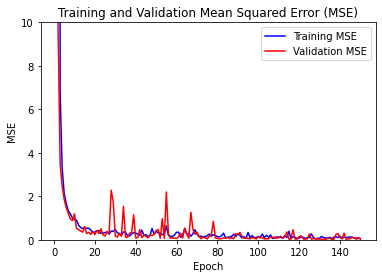

In [6]:
# ... [rest of the code remains unchanged]

import matplotlib.pyplot as plt

# Access the MSE values from the history
train_mse = history.history['loss']
val_mse = history.history['val_loss']

# Clear previous plots
plt.clf()

# Plot both training and validation MSE
plt.plot(range(1, len(train_mse) + 1), train_mse, label='Training MSE', color='blue')
plt.plot(range(1, len(val_mse) + 1), val_mse, label='Validation MSE', color='red')

# Set axis to show the range of MSE
plt.ylim([0, 10])  # Adjust the upper limit to be a bit more than the max MSE

plt.title('Training and Validation Mean Squared Error (MSE)')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()


[*********************100%%**********************]  1 of 1 completed
NAs count before filling:
Open           0
High           0
Low            0
Close          0
Adj Close      0
Volume         0
Tenkan         3
Kijun         12
Senkou A      38
Senkou B      25
UpperBand     19
LowerBand     19
MACD           0
SignalLine     0
MA             9
RSI            6
dtype: int64
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
NAs count after filling:
Open          0
High          0
Low           0
Close         0
Adj Close     0
Volume        0
Tenkan        0
Kijun         0
Senkou A      0
Senkou B      0
UpperBand     0
LowerBand     0
MACD          0
SignalLine    0
MA            0
RSI           0
dtype: int64
len normalized_train: 2100


C:\Users\beaud\AppData\Local\Temp\ipykernel_13168\2044682597.py:96: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)
C:\Users\beaud\AppData\Local\Temp\ipykernel_13168\2044682597.py:99: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dow_change.fillna(method='bfill', inplace=True)
C:\Users\beaud\AppData\Local\Temp\ipykernel_13168\2044682597.py:100: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sp500_change.fillna(method='bfill', inplace=True)


Number of Images: 2080


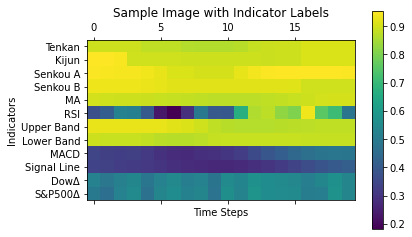

Number of Images: 2080
shapes (1664, 12, 20)
shapes2 (416, 12, 20)
Minimum values during training:
Open          2.250000e+01
High          2.291750e+01
Low           2.236750e+01
Close         2.258500e+01
Adj Close     2.079866e+01
Volume        3.145820e+07
Tenkan        2.339250e+01
Kijun         2.397500e+01
Senkou A      2.382500e+01
Senkou B      2.377500e+01
UpperBand     2.448014e+01
LowerBand     2.126893e+01
MACD         -6.673117e+00
SignalLine   -5.815683e+00
MA            2.317750e+01
RSI           0.000000e+00
dtype: float64

Maximum values during training:
Open          1.962400e+02
High          1.982300e+02
Low           1.952800e+02
Close         1.964500e+02
Adj Close     1.959270e+02
Volume        6.488252e+08
Tenkan        1.982300e+02
Kijun         1.982300e+02
Senkou A      1.982300e+02
Senkou B      1.924150e+02
UpperBand     2.035871e+02
LowerBand     1.880877e+02
MACD          7.511570e+00
SignalLine    6.895524e+00
MA            1.942150e+02
RSI           1.

104/104 [==============================] - 1s 11ms/step - loss: 4.0616 - val_loss: 5.8229
Epoch 71/400
104/104 [==============================] - 1s 10ms/step - loss: 3.4562 - val_loss: 3.4311
Epoch 72/400
104/104 [==============================] - 1s 11ms/step - loss: 3.5904 - val_loss: 4.3529
Epoch 73/400
104/104 [==============================] - 1s 10ms/step - loss: 6.0154 - val_loss: 6.3654
Epoch 74/400
104/104 [==============================] - 1s 10ms/step - loss: 4.1305 - val_loss: 3.0734
Epoch 75/400
104/104 [==============================] - 1s 10ms/step - loss: 4.1814 - val_loss: 3.4415
Epoch 76/400
104/104 [==============================] - 1s 10ms/step - loss: 3.4980 - val_loss: 3.3878
Epoch 77/400
104/104 [==============================] - 1s 10ms/step - loss: 3.5761 - val_loss: 3.2545
Epoch 78/400
104/104 [==============================] - 1s 10ms/step - loss: 3.5072 - val_loss: 3.2800
Epoch 79/400
104/104 [==============================] - 1s 10ms/step - loss: 3.6695 - 

104/104 [==============================] - 1s 10ms/step - loss: 2.6523 - val_loss: 2.6336
Epoch 150/400
104/104 [==============================] - 1s 10ms/step - loss: 2.7402 - val_loss: 2.4155
Epoch 151/400
104/104 [==============================] - 1s 10ms/step - loss: 2.4875 - val_loss: 2.9027
Epoch 152/400
104/104 [==============================] - 1s 10ms/step - loss: 2.4339 - val_loss: 2.6210
Epoch 153/400
104/104 [==============================] - 1s 10ms/step - loss: 2.7759 - val_loss: 6.3293
Epoch 154/400
104/104 [==============================] - 1s 10ms/step - loss: 2.6107 - val_loss: 2.6190
Epoch 155/400
104/104 [==============================] - 1s 10ms/step - loss: 2.6220 - val_loss: 2.6068
Epoch 156/400
104/104 [==============================] - 1s 10ms/step - loss: 2.6376 - val_loss: 2.8262
Epoch 157/400
104/104 [==============================] - 1s 10ms/step - loss: 2.5027 - val_loss: 2.3006
Epoch 158/400
104/104 [==============================] - 1s 10ms/step - loss: 

Epoch 228/400
104/104 [==============================] - 1s 10ms/step - loss: 3.1501 - val_loss: 2.7566
Epoch 229/400
104/104 [==============================] - 1s 10ms/step - loss: 2.2436 - val_loss: 2.3743
Epoch 230/400
104/104 [==============================] - 1s 10ms/step - loss: 2.7623 - val_loss: 3.0737
Epoch 231/400
104/104 [==============================] - 1s 10ms/step - loss: 2.2821 - val_loss: 3.0262
Epoch 232/400
104/104 [==============================] - 1s 10ms/step - loss: 2.3002 - val_loss: 2.2179
Epoch 233/400
104/104 [==============================] - 1s 10ms/step - loss: 2.1767 - val_loss: 2.8664
Epoch 234/400
104/104 [==============================] - 1s 10ms/step - loss: 2.9965 - val_loss: 2.3372
Epoch 235/400
104/104 [==============================] - 1s 10ms/step - loss: 2.7310 - val_loss: 4.3170
Epoch 236/400
104/104 [==============================] - 1s 10ms/step - loss: 3.5797 - val_loss: 2.1048
Epoch 237/400
104/104 [==============================] - 1s 10ms

Epoch 307/400
104/104 [==============================] - 1s 10ms/step - loss: 1.9433 - val_loss: 2.4780
Epoch 308/400
104/104 [==============================] - 1s 10ms/step - loss: 2.2118 - val_loss: 2.0367
Epoch 309/400
104/104 [==============================] - 1s 10ms/step - loss: 1.8118 - val_loss: 2.0966
Epoch 310/400
104/104 [==============================] - 1s 10ms/step - loss: 2.2466 - val_loss: 2.2053
Epoch 311/400
104/104 [==============================] - 1s 10ms/step - loss: 2.1098 - val_loss: 2.0680
Epoch 312/400
104/104 [==============================] - 1s 10ms/step - loss: 2.0071 - val_loss: 2.0350
Epoch 313/400
104/104 [==============================] - 1s 10ms/step - loss: 2.0192 - val_loss: 2.5119
Epoch 314/400
104/104 [==============================] - 1s 10ms/step - loss: 2.1451 - val_loss: 3.4738
Epoch 315/400
104/104 [==============================] - 1s 10ms/step - loss: 2.7438 - val_loss: 2.4292
Epoch 316/400
104/104 [==============================] - 1s 10ms

Epoch 386/400
104/104 [==============================] - 1s 10ms/step - loss: 1.9858 - val_loss: 3.2452
Epoch 387/400
104/104 [==============================] - 1s 10ms/step - loss: 3.1987 - val_loss: 2.0086
Epoch 388/400
104/104 [==============================] - 1s 10ms/step - loss: 2.3897 - val_loss: 2.0165
Epoch 389/400
104/104 [==============================] - 1s 10ms/step - loss: 1.8547 - val_loss: 2.9483
Epoch 390/400
104/104 [==============================] - 1s 10ms/step - loss: 2.2492 - val_loss: 1.9433
Epoch 391/400
104/104 [==============================] - 1s 10ms/step - loss: 1.8979 - val_loss: 1.9888
Epoch 392/400
104/104 [==============================] - 1s 10ms/step - loss: 2.0480 - val_loss: 2.4285
Epoch 393/400
104/104 [==============================] - 1s 10ms/step - loss: 2.0274 - val_loss: 1.8645
Epoch 394/400
104/104 [==============================] - 1s 10ms/step - loss: 2.0747 - val_loss: 2.4305
Epoch 395/400
104/104 [==============================] - 1s 10ms

In [55]:
#add indexes
#predict tomorrow's closing price given the past 7 day image input. (slow on day 2 day)
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Reshape, LSTM
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from keras.optimizers import Adam

# Download stock data
ticker = "AAPL"
data = yf.download(ticker, period="100mo", interval="1d")
# Filter out weekends (Saturday=5, Sunday=6)
data = data[data.index.dayofweek < 5]

# Calculate Ichimoku components
tenkan_period = 4
kijun_period = 13
senkou_period = 26

data['Tenkan'] = data['High'].rolling(window=tenkan_period).max()
data['Kijun'] = data['High'].rolling(window=kijun_period).max()

data['Senkou A'] = ((data['Tenkan'] + data['Kijun']) / 2).shift(senkou_period)
data['Senkou B'] = (data['High'].rolling(window=senkou_period).max() + data['Low'].rolling(window=senkou_period).min()) / 2

# Calculate Bollinger Bands 
period = 20
stdev = 2

RollingMean = data['Close'].rolling(window=period).mean()
RollingStd = data['Close'].rolling(window=period).std()

UpperBand = RollingMean + (RollingStd * stdev)
LowerBand = RollingMean - (RollingStd * stdev)

data['UpperBand'] = UpperBand
data['LowerBand'] = LowerBand

# Calculate MACD
short_window = 12
long_window = 26
macd_signal = 9

ShortEMA = data['Close'].ewm(span=short_window, adjust=False).mean()
LongEMA = data['Close'].ewm(span=long_window, adjust=False).mean()

MACD = ShortEMA - LongEMA
SignalLine = MACD.ewm(span=macd_signal, adjust=False).mean()

data['MACD'] = MACD
data['SignalLine'] = SignalLine

# Calculate additional indicators
ma_period = 10
data['MA'] = data['Close'].rolling(ma_period).mean()

# Calculate RSI without using talib
rsi_period = 7
delta = data['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
average_gain = gain.rolling(window=rsi_period).mean()
average_loss = loss.rolling(window=rsi_period).mean()
rs = average_gain / average_loss
data['RSI'] = 100 - (100 / (1 + rs))

# Check the NAs before filling
na_count_before = data.isna().sum()
print("NAs count before filling:")
print(na_count_before)

# Split data
train = data

# Download index data
dow_index = '^DJI'
sp500_index = '^GSPC'
dow_data = yf.download(dow_index, period="100mo", interval="1d")
sp500_data = yf.download(sp500_index, period="100mo", interval="1d")
# Filter out weekends
dow_data = dow_data[dow_data.index.dayofweek < 5]
sp500_data = sp500_data[sp500_data.index.dayofweek < 5]

# Calculate day-to-day percentage change for the indexes
dow_change = dow_data['Close'].pct_change()
sp500_change = sp500_data['Close'].pct_change()

# Handle NaNs
limit = 2
data.interpolate(limit=limit, limit_direction='forward', inplace=True)
data.fillna(method='bfill', inplace=True)
dow_change.interpolate(limit=limit, limit_direction='forward', inplace=True)
sp500_change.interpolate(limit=limit, limit_direction='forward', inplace=True)
dow_change.fillna(method='bfill', inplace=True)
sp500_change.fillna(method='bfill', inplace=True)

# Normalize the percentage change data
overall_min_change = pd.concat([dow_change, sp500_change]).min()
overall_max_change = pd.concat([dow_change, sp500_change]).max()

normalized_dow = (dow_change - overall_min_change) / (overall_max_change - overall_min_change)
normalized_sp500 = (sp500_change - overall_min_change) / (overall_max_change - overall_min_change)

# Normalize your training data for better visualization (scaling to the [0, 1] range)
train_min = train.min()
train_max = train.max()

normalized_train = (train - train_min) / (train_max - train_min)

# Check the NAs count after filling
na_count_after = data.isna().sum()
print("NAs count after filling:")
print(na_count_after)

print("len normalized_train:",len(normalized_train))

# Create images from the data
# Modify image_width and image_height to match your data size
image_width = 20
image_height = len(data.columns)

# Extend the image height to accommodate the indices
image_height += 2  # Add two more rows for Dow and S&P 500

# Loop through the data and create images, including the index data
images = []
for i in range(image_width, len(train)):
    image_data = np.vstack([
        normalized_train['Tenkan'].iloc[i - image_width:i],
        normalized_train['Kijun'].iloc[i - image_width:i],
        normalized_train['Senkou A'].iloc[i - image_width:i],
        normalized_train['Senkou B'].iloc[i - image_width:i],
        normalized_train['MA'].iloc[i - image_width:i],
        normalized_train['RSI'].iloc[i - image_width:i],
        normalized_train['UpperBand'].iloc[i - image_width:i],
        normalized_train['LowerBand'].iloc[i - image_width:i],
        normalized_train['MACD'].iloc[i - image_width:i],
        normalized_train['SignalLine'].iloc[i - image_width:i],
        # Append normalized index data
        normalized_dow.iloc[i - image_width:i].values,
        normalized_sp500.iloc[i - image_width:i].values
    ])
    multi_channel_image = image_data
    images.append(multi_channel_image)

# Convert the images list to a NumPy array for use in the model
X = np.array(images)

import random
# Ensure images are generated correctly
print("Number of Images:", X.shape[0])  # Print the number of images

# Plotting a random sample image
# Choose a random index for a sample image
sample_index = random.randint(0, len(images) - 1)
sample_image = images[sample_index]

# Plot the sample image
fig, ax = plt.subplots()
cax = ax.matshow(sample_image, cmap='viridis')

# Add color bar
plt.colorbar(cax)

# Define the labels for each row of the heatmap
labels = ["Tenkan", "Kijun", "Senkou A", "Senkou B", "MA", "RSI", "Upper Band", "Lower Band", "MACD", "Signal Line","DowΔ","S&P500Δ"]

# Set the tick marks and labels
ax.set_yticks(np.arange(len(labels)))
ax.set_yticklabels(labels)

# Set labels for the axes
plt.xlabel("Time Steps")
plt.ylabel("Indicators")

plt.title("Sample Image with Indicator Labels")
plt.show()

# Count the number of images
num_images = X.shape[0]
print("Number of Images:", num_images)


# Define the target variable 
y_train = train['Close'].shift(-1).dropna().values

# Ensure X and y have the same length
min_length = min(len(X), len(y_train))  # Corrected line
X = X[:min_length]
y_train = y_train[:min_length]


# Train test split
X_train, X_val, y_train, y_val = train_test_split(X, y_train, test_size=0.2)  # Adjust the test size as needed
print("shapes",X_train.shape)
print("shapes2",X_val.shape)
#X_train = X_train.reshape(X_train.shape[0], image_width, image_height, 1)
#X_val = X_val.reshape(X_val.shape[0], image_width, image_height, 1)

print("Minimum values during training:")
print(train_min)
print("\nMaximum values during training:")
print(train_max)

model = Sequential()
# CNN layers for feature extraction
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(12, 20, 1)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output of the CNN layers
model.add(Flatten())

# Reshape the output for the RNN layers
# Assuming each sequence has 'n_steps' time steps and the flattened feature size is 'feature_size'
n_steps = 16  # Adjusted based on the feature_size
feature_size = model.output_shape[1]
new_feature_size = feature_size // n_steps
model.add(Reshape((n_steps, new_feature_size)))

# RNN layer
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(LSTM(32, activation='relu'))

# Final Dense layers
model.add(Dense(64, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))

# Set a lower learning rate
learning_rate = 0.0001  # You can adjust this value; lower for m2m

# Initialize the optimizer with the desired learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compile the model with the optimizer
model.compile(optimizer=optimizer, loss='mse')

history = model.fit(
    X_train, 
    y_train, 
    epochs=400, 
    batch_size=16,
    validation_data=(X_val, y_val),  # Use the aligned y_val here
    verbose=1
)

# Evaluate the model on the validation set
mse = model.evaluate(X_val, y_val)
print("Mean Squared Error on Validation Set:", mse)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
normalized_new_data: 2100


C:\Users\beaud\AppData\Local\Temp\ipykernel_13168\701524059.py:84: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train2.fillna(method='bfill', inplace=True)
C:\Users\beaud\AppData\Local\Temp\ipykernel_13168\701524059.py:87: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dow_change.fillna(method='bfill', inplace=True)
C:\Users\beaud\AppData\Local\Temp\ipykernel_13168\701524059.py:88: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sp500_change.fillna(method='bfill', inplace=True)


Number of images used: 2080
Shape of X_new: (2080, 12, 20, 1)
65/65 [==============================] - 0s 5ms/step
Shape of Predicted Prices: (2080, 1)
Shape of Actual Prices: (2080,)
First 5 Predicted Prices: [32.12578  32.129936 32.180016 32.50028  32.608345]
First 5 Actual Prices: [29.93000031 28.37249947 28.80999947 28.78750038 28.98999977]
Train Min: Open          2.250000e+01
High          2.291750e+01
Low           2.236750e+01
Close         2.258500e+01
Adj Close     2.079866e+01
Volume        3.145820e+07
Tenkan        2.339250e+01
Kijun         2.397500e+01
Senkou A      2.382500e+01
Senkou B      2.377500e+01
UpperBand     2.448014e+01
LowerBand     2.126893e+01
MACD         -6.673117e+00
SignalLine   -5.815683e+00
MA            2.317750e+01
RSI           0.000000e+00
dtype: float64
Train Max: Open          1.962400e+02
High          1.982300e+02
Low           1.952800e+02
Close         1.964500e+02
Adj Close     1.959270e+02
Volume        6.488252e+08
Tenkan        1.982300

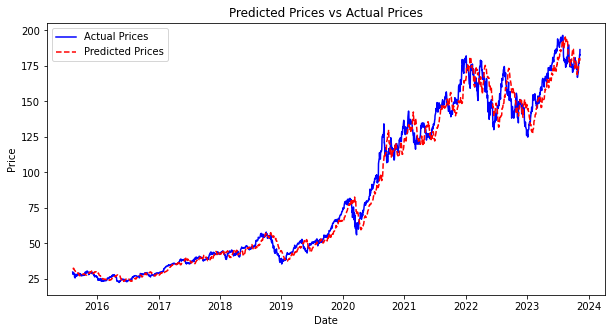

In [56]:
import pandas as pd
import numpy as np
import yfinance as yf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Download new stock data
ticker = "AAPL"
new_data = yf.download(ticker, period="100mo", interval="1d")
# Filter out weekends (Saturday=5, Sunday=6)
new_data = new_data[new_data.index.dayofweek < 5]

# Calculate Ichimoku components
tenkan_period = 4
kijun_period = 13
senkou_period = 26

new_data['Tenkan'] = new_data['High'].rolling(window=tenkan_period).max()
new_data['Kijun'] = new_data['High'].rolling(window=kijun_period).max()

new_data['Senkou A'] = ((new_data['Tenkan'] + new_data['Kijun']) / 2).shift(senkou_period)
new_data['Senkou B'] = (new_data['High'].rolling(window=senkou_period).max() + new_data['Low'].rolling(window=senkou_period).min()) / 2

# Calculate Bollinger Bands 
period = 20
stdev = 2

RollingMean = new_data['Close'].rolling(window=period).mean()
RollingStd = new_data['Close'].rolling(window=period).std()

UpperBand = RollingMean + (RollingStd * stdev)
LowerBand = RollingMean - (RollingStd * stdev)

new_data['UpperBand'] = UpperBand
new_data['LowerBand'] = LowerBand

# Calculate MACD
short_window = 12
long_window = 26
macd_signal = 9

ShortEMA = new_data['Close'].ewm(span=short_window, adjust=False).mean()
LongEMA = new_data['Close'].ewm(span=long_window, adjust=False).mean()

MACD = ShortEMA - LongEMA
SignalLine = MACD.ewm(span=macd_signal, adjust=False).mean()

new_data['MACD'] = MACD
new_data['SignalLine'] = SignalLine

# Calculate additional indicators
ma_period = 10
new_data['MA'] = new_data['Close'].rolling(ma_period).mean()

# Calculate RSI without using talib
rsi_period = 7
delta = new_data['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
average_gain = gain.rolling(window=rsi_period).mean()
average_loss = loss.rolling(window=rsi_period).mean()
rs = average_gain / average_loss
new_data['RSI'] = 100 - (100 / (1 + rs))

# Split data
train2 = new_data

# Download index data (Dow Jones and S&P 500)
dow_index = '^DJI'
sp500_index = '^GSPC'
dow_data = yf.download(dow_index, period="100mo", interval="1d")
sp500_data = yf.download(sp500_index, period="100mo", interval="1d")
# Filter out weekends
dow_data = dow_data[dow_data.index.dayofweek < 5]
sp500_data = sp500_data[sp500_data.index.dayofweek < 5]

# Calculate day-to-day percentage change for the indexes
dow_change = dow_data['Close'].pct_change()
sp500_change = sp500_data['Close'].pct_change()

# Handle NaNs
limit = 2
train2.interpolate(limit=limit, limit_direction='forward', inplace=True)
train2.fillna(method='bfill', inplace=True)
dow_change.interpolate(limit=limit, limit_direction='forward', inplace=True)
sp500_change.interpolate(limit=limit, limit_direction='forward', inplace=True)
dow_change.fillna(method='bfill', inplace=True)
sp500_change.fillna(method='bfill', inplace=True)

# Normalize the percentage change data for the indexes
overall_min_change = pd.concat([dow_change, sp500_change]).min()
overall_max_change = pd.concat([dow_change, sp500_change]).max()
normalized_dow_change = (dow_change - overall_min_change) / (overall_max_change - overall_min_change)
normalized_sp500_change = (sp500_change - overall_min_change) / (overall_max_change - overall_min_change)

# Normalize the new data using the same min and max from the training data
# Assuming 'train_min' and 'train_max' are already defined from the training data
normalized_new_data = (train2 - train_min) / (train_max - train_min)
print("normalized_new_data:",len(normalized_new_data))

# Create images from the new data
image_width = 20
image_height = 12  # Number of rows in each image (10 indicators + 2 indexes)

# Prepare the data for prediction
X_new = []

for i in range(image_width, len(normalized_new_data)):
    image_data = np.vstack([
        normalized_new_data['Tenkan'].iloc[i - image_width:i],
        normalized_new_data['Kijun'].iloc[i - image_width:i],
        normalized_new_data['Senkou A'].iloc[i - image_width:i],
        normalized_new_data['Senkou B'].iloc[i - image_width:i],
        normalized_new_data['MA'].iloc[i - image_width:i],
        normalized_new_data['RSI'].iloc[i - image_width:i],
        normalized_new_data['UpperBand'].iloc[i - image_width:i],
        normalized_new_data['LowerBand'].iloc[i - image_width:i],
        normalized_new_data['MACD'].iloc[i - image_width:i],
        normalized_new_data['SignalLine'].iloc[i - image_width:i],
        normalized_dow_change.iloc[i - image_width:i].values,
        normalized_sp500_change.iloc[i - image_width:i].values
    ])
    X_new.append(image_data)

# Print the number of images used
print("Number of images used:", len(X_new))

# Convert the list of images to a NumPy array and reshape for the model
X_new = np.array(X_new).reshape(-1, image_height, image_width, 1)

# Check the shape of the input data
print("Shape of X_new:", X_new.shape)

# Predict using the model
predicted_closing_prices = model.predict(X_new)

# Print the shapes of predictions and actual prices
print("Shape of Predicted Prices:", predicted_closing_prices.shape)
print("Shape of Actual Prices:", actual_prices.shape)

# Print the first few predicted and actual prices for comparison
print("First 5 Predicted Prices:", predicted_closing_prices.flatten()[:5])
print("First 5 Actual Prices:", actual_prices[:5])

# Print Min/Max values used for normalization
print("Train Min:", train_min)
print("Train Max:", train_max)

# Predict using the model
predicted_closing_prices = model.predict(X_new)

print("predicted:", predicted_closing_prices.flatten()[0])
print("Actual:", actual_prices[0])


# Plotting Predicted Prices (assuming we have actual closing prices for comparison)
actual_prices = new_data['Close'].iloc[image_width:].values
dates = new_data.index[image_width:]

plt.figure(figsize=(10, 5))
plt.plot(dates, actual_prices, label='Actual Prices', color='blue')
plt.plot(dates, predicted_closing_prices.flatten(), label='Predicted Prices', color='red', linestyle='dashed')
plt.title('Predicted Prices vs Actual Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()
